In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "items5"

In [2]:
library(dplyr)
library(devtools)
library(stats)
library(class)
library(ggplot2)
library(lubridate)
library(MESS)
library(rcompanion)
library(lsr)
library(dplyr)
library(glmnet)
library(caret)
library(gridExtra)
library(grid)
library(ggplot2)
library(lattice)
library(tidyverse)
library(data.table)
library(corrgram)
library(ggcorrplot)
library(dgof)
library(EnvStats)

Loading required package: usethis


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-1

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘corrgram’


Th

In [3]:
############################################################################
#####   Package mechkar                                                 ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2017-05-01                                       ####
############################################################################

############################################################################
#####   DATA VISUALIZATION                                              ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2014-03-12                                       ####
#####   Last Modified: 2020-11-03                                       ####
############################################################################

###########  Functions   ##############################################

###################################################

exploreData <- function(data=data, y=NULL, rn=NULL, factorSize=10, dir=tempdir(), debug=FALSE, ...) {

  whatVarType <- function(var) {
    suppressWarnings(if (var=="integer" | var=="numeric") {
      return(1)
    } else if (var=="factor" | var=="character") {
      return(2)
    } else if (var=="Date" | "POSIXct" %in% var[[1]]) {
      return(3)
    } else {
      return(0)
    })
  }

  drawHistogram <- function(imgname=imgname, x=x) {
    d=stats::density(x, kernel = "gaussian",na.rm=TRUE)
    breakstar=(max(x,na.rm=TRUE) -min(x,na.rm=TRUE))/d$bw
    h=graphics::hist(x, breaks=breakstar)
    graphics::plot(h,main="",xlab=imgname)
    yfit<-seq(min(x,na.rm=TRUE),max(x,na.rm=TRUE),length=40)
    ffit<-stats::dnorm(yfit,mean=mean(x,na.rm=TRUE),sd=stats::sd(x,na.rm=TRUE))
    ffit <- ffit*diff(h$mids[1:2])*length(x)
    lines(yfit, ffit, col="blue", lwd=2)
  }

  drawFakeGraph <- function(imgname=imgname) {
    graphics::plot.window(xlim = c(0,0),ylim = c(0,0))
  }

  drawBars <- function(imgname=imgname, x=x) {
    graphics::plot(x)
  }

  drawGraphOne <- function(imgname=imgname, numVar=x, vartype=1) {
    if(vartype==1) {
      drawHistogram(imgname,numVar)
    } else if(vartype==2) {
      drawBars(imgname,numVar)
    } else {
      drawFakeGraph(imgname)
    }
  }

  getContinuousStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    me <- formatC(stats::median(x, na.rm=TRUE))
    q1 <- formatC(stats::quantile(x,1/4, na.rm=TRUE))
    q3 <- formatC(stats::quantile(x,3/4, na.rm=TRUE))
    mn <- formatC(min(x, na.rm=TRUE))
    mx <- formatC(max(x, na.rm=TRUE))
    html <- paste("<div class='Cell' style='align: top;'> <u>Data type</u>: Continuous <p> <u>Data length</u>: ",n ,"/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%)<p> <u>Mean</u>: ", formatC(ma), "\t <u>StdDev</u>: ", formatC(s), "<br><u>Median</u>: ",me,
                  "\t <u>IQR</u>: ", q1, "-", q3, "<br><u>Min</u>: ", mn, "\t <u>Max</u>: ", mx, "</div>")
    return(html)
  }

  getCategortyStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    l <- levels(x)
    s <- summary(x)
    htm <- "<ul>"
    if (length(l) < 5) {
      for (lv in l) {
        htm <- paste(htm, "<li><u>", lv, "</u>: ", s[[lv]], "</li>")
      }
      htm <- paste(htm,"</ul>")
    }
    html <- paste("<div class='Cell'> <u>Data type</u>: Categorical Data <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Number of levels</u>: ", length(l), "<br>", htm, "</div>")
    return(html)
  }

  getDatesStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    s <- summary(x)
    html <- paste("<div class='Cell'> <u>Data type</u>: Date <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Min date</u>: ", min(x, na.rm=TRUE), "<br><u>Max date</u>:",max(x, na.rm=TRUE) , "</div>")
    return(html)
  }

  getStats <- function(numVar=x, vartype=1) {
    if(vartype==1) {
      html <- getContinuousStats(numVar)
    } else if(vartype==2) {
      html <- getCategortyStats(numVar)
    } else if (vartype==3) {
      html <- getDatesStats(numVar)
    } else {
      html <- "<div class='Cell'></div>"
    }
    return(html)
  }

  getOutliers <- function(x) {
    bp <- graphics::boxplot(x,plot=FALSE)
    return(bp$out)
  }

  getOutlierGraph <- function(x) {
    #  mod <- tryCatch({
    outl <- getOutliers(x)
    df <- data.frame(x=x, cl=1)
    if(length(outl)>0) {
      df$cl[which(df$x %in% outl)] <- 2
    }
    #pl <- stats::scatter.smooth(df$x,col=df$cl)
    pl <- tryCatch({
      stats::scatter.smooth(df$x,col=df$cl,xlab="index")
    }, warning = function(w) {
      suppressWarnings(w)
      #n <- "warning!"
    }, error = function(e) {
      n <- "error!"
    }, finally = {
      graphics::plot(df$x ~ row.names(df),col=df$cl,xlab="index")
    })
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    graphics::abline(h=ma-(2*s), col="red", lty=2)
    graphics::abline(h=ma+(2*s), col="red", lty=2)
    #  }, error = function(e) {
    #    pl <- drawFakeGraph("none")
    #  })
    return(pl)
  }

  #' @importFrom rlang .data
  getScatterGraph <- function(df=data,x,y,dtype=1) {
    if(dtype==1) {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_smooth(ggplot2::aes(x=.data[[x]], y=.data[[y]]), method="loess") + ggplot2::xlab(x) + ggplot2::ylab(y)
    } else {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_boxplot(ggplot2::aes(y=.data[[x]], color=.data[[y]])) + ggplot2::xlab(x) + ggplot2::ylab(y) + ggplot2::labs(color=y)
    }
    return(pl)
  }

  getOutliersHtml <- function(imgname=imgname, x=x, srcdir=srcdir) {
    bp <- getOutliers(x)
    if (length(unique(bp)) > 10) {
      xtrm <- paste("There are ", length(unique(bp)), " outlier values")
    } else if (length(unique(bp)) == 0) {
      xtrm <- "No outlier values found"
    } else {
      xtrm <- paste(formatC(unique(bp)), collapse=', ' )
    }
    #imgsrc = paste(paste0(srcdir,"/fig/"),imgname, "_2.png",sep="")
    imgsrc = paste(paste0("fig/"),imgname, "_2.png",sep="")
    html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='250'><br> <u>Outlier values</u>: <br> ", xtrm, "</div>")
    return(html)
  }
  ################## Prepare for the report ###################
  #report <- paste(mydir,"/report",sep="")

  ################## Check for values for rn ##################
  if(!is.null(rn)) {
    if(length(rn)!=ncol(data)) {
      message("the value of the 'rn' argument was avoided because it does not have the same number of columns of the dataframe")
      rn <- NULL
    }
    xname <- rn
    names(xname) <- names(data)
  } else {
    xname <- NULL
  }

  report <- dir
  if (!file.exists(report)) {
    dir.create(report)
  }
  fig <- paste(report,"/fig",sep="")
  if (!file.exists(fig)) {
    dir.create(fig)
  }
  srcdir <- report

  # determine which columns are integer
  int_col <- which(sapply(data, is.integer))
  int_col <- c(int_col,(which(sapply(data, is.numeric))))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in int_col) {
    if (length(unique(data[,li])) < factorSize) {
      mi <- c(mi,li)
      if (is.factor(data[,li]) == FALSE) {
        data[,li] <- factor(data[,li])
      }
    }
  }

  str_col <- which(sapply(data, is.character))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in str_col) {
    mi <- c(mi,li)
    data[,li] <- factor(data[,li])
  }

  # create the html report page
  myhtml <- paste(report,"/report.html",sep="")
  cat("<!DOCTYPE html>
      <html>
      <head>
      <title>Data Visualization</title>
      <meta http-equiv='Content-Type' content='text/html; charset=UTF-8' />
      <link rel='stylesheet' href='http://code.jquery.com/mobile/1.4.5/jquery.mobile-1.4.5.min.css'>
      <script src='http://code.jquery.com/jquery-1.10.2.js'></script>
      <script>
      $(document).ready(function(){
      $('.onetoone').hide();
      });
      $(function() {
      $('.origimg').click(function(e) {
      $('#popup_img').attr('src',$(this).attr('src'));
      $('#myContainer').hide();
      var pos = $(document).scrollTop();
      $('#myContainer').css({'top':pos+20,'left':250, 'position':'absolute', 'border':'1px solid black', 'padding':'0px'});
      $('#myContainer').show();
      });
      $('#myContainer').click(function(e) {
      $('#myContainer').hide();
      });
      $('#myform2').submit(function(e) {
      e.preventDefault();
      });
      $('#onetoone').on('click',function() {
      console.log('onetone button - 1');
      $('#onetoone').hide();
      $('#aslist').show();
      // To show only individual rows:
      $('.Row').hide();
      $('.onetoone').show();
      // then we iterate
      var i = $('.Row').length;
      // Then we iterate
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('onetone button - 2');
      });
      $('#aslist').on('click',function() {
      console.log('aslist button - 1');
      $('#onetoone').show();
      $('#aslist').hide();
      $('.onetoone').hide();
      $('.Row').show();
      console.log('aslist button - 2');
      });
      $('#less').on('click',function(){
      console.log('less button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) - 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('less button - 2');
      });
      $('#more').on('click',function(){
      console.log('more button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) + 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('more button - 2');
      });
      $('#idx').on('change', function(){
      console.log('idx changed - 1');
      var i = $('.Row').length;
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('idx changed - 2');
      });
      });
      </script>
      <style type='text/css'>
      .Table
      {
      display: table;
      }
      .Title
      {
      display: table-caption;
      text-align: center;
      font-weight: bold;
      font-size: larger;
      background-color:#4C6F50;
      color: #fff;
      }
      .Row
      {
      display: table-row;
      }
      .Row:nth-child(even) {
        background-color: #56882433;
      }
      .Cell
      {
      display: table-cell;
      border: solid;
      border-width: thin;
      padding-left: 5px;
      padding-right: 5px;
      vertical-align: top;
      font-family: Arial, Helvetica, sans-serif;
      font-size: 14px;
      }
      </style>
      </head>
      <body>
      <div id='pageone' data-role='main' class='ui-content'>
      ", file = myhtml, sep='\n',append=FALSE)

  html <- paste("<p><p><h1> Data Visualization & Exploration </h1>
                <form>
                <input type='button' id='onetoone' value='Show as Cards'>
                <input type='button' id='aslist' class='onetoone' value='Show as List'>
                </form>
                <p>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # begin table
  alt1 <- ifelse(is.null(y)== TRUE, "", "<div class='Cell Title'> Dependent <br> Variable <br> Distribution </div>")
  html <- paste("<p><p>
                <div class='Table'>
                <div class='Row'>
                <div class='Cell Title'> Variable </div>
                <div class='Cell Title'> Distribution </div>
                <div class='Cell Title'> Descriptive <br> Statistics</div>
                <div class='Cell Title'> Outliers </div>"
                , alt1,
                "</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)

  #### determinate the type of each variable...
  data_types <- sapply(sapply(data, class), whatVarType)
  ln <- length(data)
  ii <- 0
  pb <- utils::txtProgressBar(min=0,max=ln,style=3)
  for(x in names(data)) {

    ## check if the value has at least more than one unique value...
    if(length(unique(data[[x]])) < 2) {
      message(paste("The variable",x,"has less than two unique values, so will not be included"))
    } else {

      if(debug==TRUE) {
        message(x)
      } else {
        pb <- utils::txtProgressBar(min=0,max=ln,style=3)
      }

      html <- paste("<div class='Row'><div class='Cell'><b>",x,"</b><p>",xname[x],"</p></div>")

      cat(html, file = myhtml, sep='\n', append=TRUE)
      #### initialize the first graph
      imgname = paste(fig,"/",x, "_1.png",sep="")
      #imgsrc = paste(paste0(srcdir,"/fig/"),x, "_1.png",sep="")
      imgsrc = paste("fig/",x, "_1.png",sep="")
      ### send the data with the type to generate the correct graph..
      grDevices::png(imgname)
      drawGraphOne(x, data[[x]], data_types[x])
      grDevices::dev.off()
      html <- paste0("<div class='Cell'><img class='origimg'  src='",imgsrc,"' height='150' width='150'><br></div>")
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # second, show the statistics
      html <- getStats(data[[x]],data_types[x])
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # third, determine the outliers
      imgname = paste(fig,"/",x, "_2.png",sep="")
      if(data_types[x]==1) {
        grDevices::png(imgname)
        getOutlierGraph(data[[x]])
        grDevices::dev.off()
        html <- getOutliersHtml(x,data[[x]],srcdir)
      } else {
        html <- "<div class='Cell'></div>"
      }
      cat(html, file = myhtml, sep='\n', append=TRUE)

      # fourth, if y is assigned, make a corresponding plot
      if(is.null(y)==FALSE) {
        imgname = paste(fig,"/",x, "_3.png",sep="")
        #imgsrc = paste(paste0(srcdir,"/fig/"),x, "_3.png",sep="")
        imgsrc = paste("fig/",x, "_3.png",sep="")
        grDevices::png(imgname)
        ### scatter.smooth(data[[x]] ~ data[[y]])
        #suppressWarnings(getScatterGraph(data,x,y,data_types[y]))
        plot(getScatterGraph(data,x,y,data_types[y]))
        grDevices::dev.off()
        html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='150'><br></div>")
        cat(html, file = myhtml, sep='\n', append=TRUE)
      }
      html <- paste("</div>")
      cat(html, file = myhtml, sep='\n', append=TRUE)

      if(debug==FALSE) {
        utils::setTxtProgressBar(pb,ii)
        ii <- ii + 1
      }
    }
  }
  utils::setTxtProgressBar(pb,ln)
  html <- paste("</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # end table
  html <- paste("</div>
                <div data-role='popup' id='myContainer' style='display: none;'>
                <img id='popup_img' src='' />
                </div>
                </div>
                </div>
                </div>
                <p>
                <div class='onetoone'>
                <form id='myform2'>
                <span> <input type='button' id='less' value=' << '> </span>
                <span> <input id='idx' name='idx' value='1'></input></span>
                <span> <input type='button' id='more' value=' >> '> </span>
                </form>
                </div>
                <p>
                </body></html>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  ## call the default browser or the one which is open (if any)
  browseURL(myhtml)
}

###################### END exploreData ###############


############################################################################
#####   TABLE 1                                                         ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-03-09                                       ####
#####   Last Modified: 2020-11-03                                       ####
############################################################################

####################  FUNCTIONS  ###########################################
#### Usage:
####   x: character vector with the name of the variables
####   y: the name of the strata variable (optional)
####   rn: character vector with the text we want to replace the variable names
####   data: the dataset to be used
####   miss: include missing statistics: [0=none, 1=only for categorical variables, 2=for all variables]
####   excel: export the table to excel [0=no, 1=yes]
####   excel_file: the name of the excel file we want to save the table (optional)
####
###################

Table1 <- function(x=NULL, y=NULL, rn=NULL, data=NULL, miss=3, catmiss=TRUE, formatted=TRUE, categorize=FALSE,
                    factorVars=NULL, maxcat=10, delzero=TRUE, decimals=1, messages=TRUE, excel=0, excel_file=NULL,
                    debug=FALSE) {
  ### define sub-functions
  Del <- NULL
  Pop <- NULL
  n <- NULL
  g1 <- function(var)c(Mean=mean(var,na.rm=TRUE), SD=stats::sd(var,na.rm=TRUE))
  g2 <- function(var)c(Median=stats::median(var,na.rm=TRUE), IQR=stats::quantile(var,c(0.25,0.75),na.rm=TRUE))
  msg <- NULL
  
  ### function for transforming variables to factors
  setFactors <- function(data=data, factorVars=factorVars, catmiss=catmiss, maxcat=maxcat) {
    if(is.null(factorVars)==TRUE) {
      aa <- sapply(sapply(data, unique), length)
      factorVars <- names(which(aa <= maxcat))
    }
    for (v in factorVars) {
      ct <- ifelse( ((is.null(factorVars)==FALSE & (v %in% factorVars)) | (is.null(factorVars)==TRUE & length(unique(data[[v]])) <= maxcat)),1,0)
      if (ct == 1) {
        data[[v]] <- factor(data[[v]])
        if(catmiss == TRUE & sum(is.na(data[[v]])==TRUE) > 0) {
          data[[v]] <- factor(data[[v]],levels=c(levels(data[[v]]),"Missing"))
          data[[v]][which(is.na(data[[v]])==TRUE)] <- "Missing"
        }
      }
    }
    return(data)
  }
  ### proceed to convert varibles to factors
  if (categorize == TRUE | is.null(factorVars)==FALSE ) {
    data <- setFactors(data, factorVars, catmiss, maxcat)
  }
  
  getSimpleTable  <- function(x=x, rn=rn, data=data, miss=miss, catmiss=catmiss,formatted=formatted,
                              categorize=categorize,maxcat=maxcat, delzero=delzero) {
    if (is.null(x)==TRUE) { x <- names(data)}
    if (is.null(rn)==TRUE) { rn <- x}
    ln <- length(x)
    pb <- utils::txtProgressBar(min=0,max=ln,style=3)
    msg <- NULL
    ### define the column names
    tableaaaa <- cbind(Del="Del",V1="Variables",V2="Categories",n="n","Population")
    tablebbbb <- cbind(Del="Del",V1="Variables",V2="Categories",n="n",val1="val1",val2="val2",val3="val3")
    tbl1 <- cbind(0,"Individuals","n",n=1, nrow(data))
    tbl2 <- cbind(0,"Individuals","n",n=1, nrow(data),NA,NA)
    tableaaaa <- rbind(tableaaaa,tbl1)
    tablebbbb <- rbind(tablebbbb,tbl2)
    q <- 1
    n <- 1
    ii <- 1
    for (v in x)
    {
      if (v %in% names(data)) {
        ### define if the actual variable has to be treated as numeric or factor
        ct <- ifelse(is.numeric(data[[v]])==TRUE & categorize==TRUE &
                       ((is.null(factorVars)==FALSE & (v %in% factorVars)) |
                          (is.null(factorVars)==TRUE & length(unique(data[[v]])) <= maxcat)),1,0)
        ### treat as numeric
        if (length(unique(data[v]))==0) {
          if (messages==TRUE) {
            msg <- c(msg, paste("The variable",v,"has no data; avoided"))
          }
        } else if (inherits(data[[v]], "Date")==TRUE) {
          if (messages==TRUE) {
            msg <- c(msg, paste("The variable",v,"is a date. Dates are not allowed in Table1; avoided"))
          }
        } else if (is.numeric(data[[v]])==TRUE & ct==0) {
          ## report mean and standard deviation
          t_n <- g1(data[[v]])
          tp <- paste(format(round(t_n[1],decimals),nsmall=1,big.mark=",")," (", format(round(t_n[2],decimals),nsmall=1,big.mark=","),")",sep="")
          tbl1 <- cbind(0,rn[q],"Mean (SD)",n=1, tp)
          tbl2 <- cbind(0,rn[q],"Mean (SD)",n=1,t_n[1],t_n[2],NA)
          tableaaaa <- rbind(tableaaaa,tbl1)
          tablebbbb <- rbind(tablebbbb,tbl2)
          ## report median and Interquartile ranges (25%,75%)
          t_n <- g2(data[[v]])
          tp <- paste(format(round(t_n[1],decimals),nsmall=1,big.mark=",")," (", format(round(t_n[2],decimals),nsmall=1,big.mark=","),"-", format(round(t_n[3],decimals),nsmall=1,big.mark=","), ")",sep="")
          tbl1 <- cbind(0,rn[q],"Median (IQR)",n=2, format(tp,big.mark=","))
          tbl2 <- cbind(0,rn[q],"Median (IQR)",n=2,t_n[1],t_n[2],t_n[3])
          tableaaaa <- rbind(tableaaaa,tbl1)
          tablebbbb <- rbind(tablebbbb,tbl2)
          ## report number and percent of missing
          if (miss >= 1) {
            datams <- subset(data,is.na(data[[v]])==TRUE)
            if (nrow(datams)>0) {
              data$cnt <- 1
              datams$cnt <- 1
              t_n <- table(data$cnt)
              t_m <- sum(datams$cnt)
              tp <- paste(format(t_m,big.mark=",")," (",format(round((t_m/t_n)*100,decimals),nsmall=1,big.mark=","),"%)",sep="")
              tbl1 <- cbind(0,rn[q],"Missing (%)",n=3, tp)
              tbl2 <- cbind(0,rn[q],"Missing (%)",n=3, t_m, (t_m/t_n)*100, NA)
            } else {
              tbl1 <- cbind(1,rn[q],"Missing (%)",n=3, " -- ")
              tbl2 <- cbind(1,rn[q],"Missing (%)",n=3, NA, NA, NA)
            }
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
        } else {
          t_n <- table(data[[v]])
          ttotal <- sum(t_n)
          nm <- row.names(t_n)
          for (f in 1:length(nm)) {
            del1 <- ifelse(length(nm)==2 & (nm[f]=="No" | nm[f]=="no" | nm[f]==0 | nm[f]=="0" | nm[f]=="None" | nm[f]=="none"),1,0)
            tp <- t_n[f] / ttotal * 100
            pct <- paste(format(round(t_n[f],decimals),nsmall=0,big.mark=",")," (", format(round(tp,decimals),nsmall=1,big.mark=","), "%)",sep="")
            tbl1 <- cbind(del1,rn[q],nm[f],n=f, pct)             ########### delete rows 0/1 !!!!!!!!!
            tbl2 <- cbind(del1,rn[q],nm[f],n=f, t_n[f], tp, NA)  ########### delete rows 0/1 !!!!!!!!!
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
          if (miss >= 2 & catmiss==FALSE ) {
            datams <- subset(data,is.na(data[[v]])==TRUE)
            if (nrow(datams)>0) {
              data$cnt <- 1
              datams$cnt <- 1
              t_n <- table(data$cnt)
              t_m <- sum(datams$cnt)
              tp <- paste(format(t_m,big.mark=",")," (",format(round((t_m/t_n)*100,decimals),nsmall=1,big.mark=","),"%)",sep="")
              tbl1 <- cbind(0,rn[q],"Missing (%)",n=f, tp)
              tbl2 <- cbind(0,rn[q],"Missing (%)",n=f, t_m, (t_m/t_n)*100, NA)
            } else {
              tbl1 <- cbind(1,rn[q],"Missing (%)",n=f, " -- ")
              tbl2 <- cbind(1,rn[q],"Missing (%)",n=f, NA, NA, NA)
            }
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
        }
      } else {
        if (messages==TRUE) {
          msg <- c(msg, paste("The variable",v,"doesn't exists in the dataset; avoiding"))
        }
      }
      q <- q + 1
      if(debug==FALSE) {
        utils::setTxtProgressBar(pb,ii)
        ii <- ii + 1
      } else {
        message(v)
      }
    }
    if(formatted==TRUE) {
      return(tableaaaa)
    } else {
      return(tablebbbb)
    }
    close(pb)
  }
  
  pvals <- function(x=x,y=y,rn=rn,data=data,categorize=categorize,maxcat=maxcat) {
    ptab <- NULL
    if (is.null(y)==FALSE) {
      if (y %in% names(data)) {
        if (is.null(x)==TRUE) { x <- names(data)}
        if (is.null(rn)==TRUE | length(rn)<2) {rn <- x}
        q <- 1
        ptab <- cbind(V="Variables",pval="pval", n="n")
        
        ln <- length(x)
        ii <- 0
        pb <- utils::txtProgressBar(min=0,max=ln-1,style=3)
        
        for (v in x) {
          if (v %in% names(data)) {
            ct <- ifelse(is.numeric(data[[v]])==TRUE & categorize==TRUE & length(unique(data[[v]])) <= maxcat,1,0)
            if (is.numeric(data[[y]])==TRUE & categorize==TRUE & length(unique(data[[y]])) <= maxcat) {
              data[[y]] <- as.factor(data[[y]])
            } else if (is.numeric(data[[y]])==TRUE) {
              if (messages==TRUE) {
                msg <- c(msg, paste("The variable",y,"is not a factor. Please convert to factor or change the 'categorize' flag to TRUE."))
              }
              pval <- "Please rerun!!!"
            }
            if (is.numeric(data[[v]])==TRUE & length(unique(data[[v]])) > 1 & ct == 0) {
              ### first check for homoscedasticity
              tryCatch({
                if (stats::bartlett.test(data[[v]], data[[y]])[3] >= 0.05) {
                  pval <- suppressMessages(round(as.numeric(suppressMessages(car::Anova(stats::lm(data[[v]] ~ data[[y]])))[1, 4]), 3))
                } else {
                  pval <- suppressMessages(round(as.numeric(suppressMessages(car::Anova(stats::lm(data[[v]] ~ data[[y]]), white.adjust = TRUE))[1, 3]), 3))
                }
              }, warning = function(w) {
                suppressWarnings(w)
                #ww <- "suppress warnings"
              }, error = function(e) {
                pval <- "---"
              })
            } else if (length(unique(data[[v]]))==1) {
              pval <- NA
            } else {
              if(length(unique(data[[v]])) < 15) {
                if (min(table(data[[v]],data[[y]])) > 5) {
                  pval <- round(as.numeric(stats::chisq.test(data[[v]],data[[y]])$p.val),3)
                } else {
                  if(min(table(data[[v]],data[[y]]))==0) {
                    #in cases where there are cells with zero, we use Fisher's exact test
                    tryCatch(
                      pval <- round(as.numeric(stats::fisher.test(data[[v]],data[[y]], workspace=1e9)$p.val),3),
                      error = function(e) {msg <- c(msg,paste0("Unable to calcualte the Fisher test for variables ",v," and ",y))})
                  } else {
                    pval <- round(as.numeric(stats::kruskal.test(data[[v]],data[[y]], workspace=1e9)$p.val),3)
                  }
                }
              } else {
                pval <- NA
              }
            }
            ptab <- rbind(ptab,cbind(V=rn[q],pval=pval,n=2))
          }
          if(debug==FALSE) {
            utils::setTxtProgressBar(pb,ii)
            ii <- ii + 1
          }
          q <- q + 1
        }
      }
    }
    return(ptab)
  }
  ####################### Begin analysis
  ##### check for x's witch have one unique values, get them out.
  vv <- NULL
  j <- 0
  jj <- NULL
  for(v in x) {
    if(length(unique(data[[v]])) < 2) {
      vv <- c(vv,v)
      j <- j + 1
      jj <- c(jj,j)
    }
  }
  
  if (length(vv)>0) {
    warning(paste("The following variables have unique values and will not be included in the analysis:",vv))
    x <- setdiff(x, vv)
    if(is.null(rn)==FALSE & length(jj)>0) {
      rn <- rn[-jj]
    }
  }
  
  ##### if y is null then make a simple table
  tabaaa1 <- getSimpleTable(x=x, rn=rn, data=data, miss=miss, catmiss=catmiss,formatted=formatted,categorize=categorize,maxcat=maxcat, delzero=delzero)
  tabaaa1 <- as.data.frame(tabaaa1)
  ############################  CHANGE TO 5 !!!!!!!!!!!!!!
  if(length(tabaaa1) > 5) {
    names(tabaaa1) <- c("Del","V1","V2","n","Pop","pop2","pop3")
  } else {
    names(tabaaa1) <- c("Del","V1","V2","n","Pop")
  }
  ##### if y has two levels, then make a compound comparison
  if (is.null(y)==FALSE){
    if (y %in% names(data)) {
      if (is.factor(data[[y]])==FALSE) {
        if (length(levels(factor(data[[y]]))) > 8) {
          if (messages==TRUE) {
            message("The dependent variable has more than 8 levels, table too large!")
          }
        } else if(min(table(data[[y]]))==0) {
          message("The dependent variable has one or more levels with no individuals assigned!")
        } else {
          data[[y]] <- factor(data[[y]])
        }
      }
      if (length(levels(data[[y]])) >= 2) {
        for (lv in levels(data[[y]])) {
          dtsub <- subset(data, data[[y]]==lv)
          tab <- getSimpleTable(x=x, rn=rn, data=dtsub, miss=miss, catmiss=catmiss, formatted=formatted,categorize=categorize,maxcat=maxcat, delzero=delzero)
          tab <- data.frame(tab)
          ############################  
          if(length(tab) > 5) {
            names(tab) <- c("Del","V1","V2","n",paste0(lv,"_1"),paste0(lv,"_2"),paste0(lv,"_3"))
          } else {
            names(tab) <- c("Del","V1","V2","n",lv)
          }
          ############################  
          tab[1,5] <- lv
          tabaaa1 <- base::merge(tabaaa1, tab, all.x=TRUE)
        }
        # what to do with dichotomous variables? We remove the "Zero" label
        # clean unnecesary rows
        if (delzero == TRUE) {
          tabaaa1 <- tabaaa1[tabaaa1$Del==0,]
        }
        ### calculate the p-value
        ptab <- data.frame(pvals(x=x,y=y,rn=rn,data=data,categorize=categorize,maxcat=maxcat))
        names(ptab) <- c("V1","pval","n")
        tabaaa1 <- base::merge(tabaaa1, ptab,all.x=TRUE)
        tabaaa1 <- tabaaa1[tabaaa1$Pop != " -- ",]
      }
    }
  }
  
  tabaaa1$n <- NULL
  tabaaa1$Del <- NULL
  ### format the table for printing
  n <- ncol(tabaaa1)
  names(tabaaa1)[1] <- "Variables"
  names(tabaaa1)[2] <- ""
  names(tabaaa1)[3] <- "Population"
  names(tabaaa1)[n] <- "p-value"
  tabaaa1[,n] <- as.character(tabaaa1[,n])
  tabaaa1[,n] <- ifelse(is.na(tabaaa1[,n]),"",tabaaa1[,n])
  tabaaa1[,n] <- ifelse(tabaaa1[,n]=='0',"<0.001",tabaaa1[,n])
  
  ##### check for export to excel
  if (excel==1) {
    writexl::write_xlsx(tabaaa1,excel_file)
    return(tabaaa1)
  } else {
    return(tabaaa1)
  }
}

########################## END Table1 ###############


############################################################################
#####   TEST & TRAIN DATASET GENERATION                                 ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-08-17                                       ####
#####   Last Modified: 2020-11-03                                       ####
############################################################################

train_test <- function(data=NULL,train_name=NULL,test_name=NULL,prop=NULL,seed=123,tableone=FALSE)
{
  pval <- NULL
  checkTrainTest <- function(train=NULL,test=NULL) {
    train[["traintest_ind_"]] <- 1
    test[["traintest_ind_"]] <- 2
    df <- rbind(train, test)
    tab <- Table1(data=df, y="traintest_ind_",messages = FALSE)
    vars <- subset(tab, pval < 0.05)$V1
    vars <- setdiff(vars,"traintest_ind_")
    if (length(vars)==0) {
      message(" ")
      message("You got a perfectly balanced training and test datasets")
      message(" ")
    } else {
      message("WARNING: The following variables are not balanced between the training and test datasets:")
      for (v in vars) { message(paste("*",v)) }
      message("You can try to change the seed value until you get a balanced partition.")
      message("Alternatively, you can ommit this warning and exclude those variables from your model")
      message(" ")
    }
    return(tab)
  }
  nm <- 1
  ttenv = as.environment(nm)
  ## set the seed to make your partition reproductible
  set.seed(seed)
  smp_size <- floor(prop * nrow(data))
  train_ind <- sample(seq_len(nrow(data)), size = smp_size)
  assign(train_name, data[train_ind, ], envir=ttenv)
  assign(test_name, data[-train_ind, ], envir=ttenv)
  message(paste("Dataset partitioned into:"))
  message(paste(" + Train dataset:", train_name))
  message(paste(" + Test dataset:", test_name))
  if(tableone==TRUE) {
    tab <- checkTrainTest(get(train_name),get(test_name))
    tab <- tab[tab[,1]!="traintest_ind_",]
    names(tab)[4] <- train_name
    names(tab)[5] <- test_name
    return(tab)
  }
}


######################### END train_test ###############


############################################################################
#####   TABLE 2                                                         ####
#####   Description: calculates the Odds/Hazard ratios and their        ####
#####     confidence intervals from a given model
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-03-09                                       ####
#####   Last Modified: 2018-04-16                                       ####
############################################################################

Table2 <- function(mod, rv=NULL,level=0.95, decimals=3) {
  alpha <- 1-level
  msm <- suppressMessages(summary(mod))
  if(rlang::has_name(msm,"coefficients")==TRUE) {
    msm <- msm$coefficients
  } else if(rlang::has_name(msm,"coef")==TRUE) {
    msm <- msm$coef
  }
  if("coxph" %in% class(mod)) {
    exp_coef <- msm[,1]
    dd <- suppressMessages(exp(stats::confint(mod, level=level)))
    dd1 <- round(dd[,1],decimals)
    dd2 <- round(dd[,2],decimals)
    p_value <- round(msm[,ncol(msm)],decimals)
  } else {
    ciz <- stats::qnorm(1-(alpha/2))
    exp_coef <- exp(msm[, 1])
    se_exp_coef <- msm[,2] * exp_coef
    dd1 <- round(exp_coef - ciz * se_exp_coef, decimals)
    dd2 <- round(exp_coef + ciz * se_exp_coef, decimals)
    exp_coef <- round(exp_coef, decimals)
    z<- abs((exp_coef-1)/se_exp_coef)
    p_value <- round(2*(1-stats::pnorm(z)), decimals)
  }
  tb <- data.frame(cbind(Estimate=exp_coef,'CI_lo'=dd1,'CI_hi'=dd2,'p value'=p_value))
  if (is.null(rv)==FALSE) {
    row.names(tb) <- rv
  } else {
    row.names(tb) <- names(mod$coefficients)
  }
  return(tb)
}

############################################################################
#####   TABLE2 WITH FORESTPLOT                                          ####
#####   Description: Generates a publication ready version of a model   ####
#####      risk table with a forestplot graph inside it                 ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2018-05-17                                       ####
############################################################################
Table2.forestplot <- function(mod, nr=NULL) {
  opar <- graphics::par(no.readonly = TRUE)
  on.exit(graphics::par(opar))
  tryCatch({tbA <- Table2(mod)},
           error=function(cond) {
             message("This model type is not supported !")
             return(NA)
           })
  if(exists("tbA")) {
    ## max value for x axis
    xmax <- max(tbA[,3])
    if(xmax < 5) {
      #axis(1, seq(0,xmax,by=.5), cex.axis=.5)
     rh <- 12
    } else {
      rh <- 18
    }
    colnames(tbA) <- c("coef","ci_low","ci_high","p_value")
    j <- nrow(tbA)
    nm <- row.names(tbA)
    rowseq <- seq(nrow(tbA),1)
    graphics::par(mai=c(1,0,0,0),new=FALSE)
    graphics::plot(tbA$coef, rowseq, pch=15,
         xlim=c(-10,rh), ylim=c(0,j+3),
         xlab='', ylab='', yaxt='n', xaxt='n',
         bty='n')
    for (i in 1:j) {
      graphics::abline(h=i-0.5,lwd=1, lty=3, col="gray")
    }
    graphics::par(new=TRUE)
    graphics::plot(tbA$coef, rowseq, pch=15,
         xlim=c(-10,rh), ylim=c(0,j+3),
         xlab='', ylab='', yaxt='n', xaxt='n',
         bty='n')
    graphics::axis(1, seq(0,xmax,by=.5), cex.axis=.5)
    graphics::segments(1,-1,1,j, lty=3)
    graphics::segments(tbA$ci_low, rowseq, tbA$ci_hi, rowseq)
    graphics::mtext('Lower risk',1, line=2.5, at=0, cex=.5, font=2)
    graphics::mtext('Higher risk',1.5, line=2.5, at=2, cex=.5, font=2)
    if (is.null(nr)) {
      nr <- data.frame(vars=names(mod$coefficients))
      col2 <- as.character(gsub(x=nr$vars, pattern=paste(names(mod$xlevels),collapse="|"),replacement=" "))
      col3 <- data.frame(vars=as.character(NULL),col3=as.character(NULL))
      for(n in names(mod$xlevels)) {
        col3 <- rbind(col3, cbind(vars=paste(n,levels(mod$data[[n]])[2],sep=""),col3=n))
      }
      nr$col1 <- ifelse(nr$vars %nin% setdiff(names(mod$coefficients),names(mod$data)),as.character(nr$vars),'')
      nr$col2 <- ifelse(nr$vars %nin% col2, col2, " ")
      nr[1,"col1"] <- ifelse(nr[1,"vars"]=="(Intercept)","(Intercept)",nr[1,"vars"])
      nr$col1 <- ifelse(nr$vars %in% col3, col3, nr$col1)
      nr <- merge(nr,col3, x.all=TRUE)
      nr$col1 <- ifelse(is.na(nr$col3)==TRUE,nr$col1,as.character(nr$col3))
      nr$col1 <- ifelse(grepl(":",nr$vars),nr$vars,nr$col1)
    } else {
      nr <- data.frame(vars=nr)
      if (length(nm)==nrow(nr)) {
        nr <- cbind(nm,nr)
        colnames(nr) <- c("vars","col1","col2")
      } else {
        return("The number of variables in the table of names (nr) you give is not equal to the number of variables in the model.
               Please check the names you entered in the table.")
      }
    }
    ### this part writes the variable titles
    graphics::text(-10,j+2, "Variables", cex=.75, font=2, pos=4)
    graphics::abline(h=j+1, col="gray", lwd=1.5, lty=1)
    graphics::text(-10,rowseq, nr[,2], cex=.75, pos=4, font=3)
    ### and this writes the categories for nominal variables
    graphics::text(-6,rowseq, nr[,3], cex=.75, pos=4)
    graphics::text(-3,j+2, "Odds Ratio (95% CI)", cex=.75, font=2, pos=4)
    t3 <- ifelse(!is.na(tbA$coef),
                 with(tbA, paste(format(coef,nsmall = 3,digits = 3),' (',format(ci_low,nsmall = 3,digits = 3),'-',format(ci_high,nsmall = 3,digits = 3),')',sep='')), '')
    graphics::text(xmax,rowseq, t3, cex=.75, pos=4, bg="lightgreen")
    graphics::text(xmax+5,j+2, "P Value", cex=.75, font=2, pos=4)
    t4 <- ifelse(!tbA$p_value==0, paste0(" ",format(tbA$p_value,nsmall = 3,digits = 3)), '<0.001')
    graphics::text(xmax+5,rowseq, t4, cex=.75, pos=4)
    graphics::box(which = "outer",col="darkgray",lwd=3)
  }
  graphics::par(mai=c(1,1,1,1),new=FALSE)
}

############################################################################
#####   CALCULATE CONFIDENCE INTERVALS FOR MEANS                        ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-08-24                                       ####
############################################################################
MeanCI <- function(x,round=3) {
  m <- mean(x,na.rm=TRUE)
  s <- stats::sd(x,na.rm=TRUE)
  ci <- 1.96 * (s/sqrt(length(x)))
  CImin <- m - ci
  CImax <- m + ci
  return(c(mean=round(m,round),CImin=round(CImin,round),CImax=round(CImax,round)))
}

############################################################################
#####   CALCULATE CONFIDENCE INTERVALS FOR PROPORTIONS                  ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-08-24                                       ####
############################################################################
PropCI <- function(x,round=3,multi=100,ref=2) {
  recode <- function(x,ref) {
    y <- x
    if (ref==2) {
      y[which(x==min(x))] <- 0
      y[which(x==max(x))] <- 1
    } else {
      y[which(x==max(x))] <- 0
      y[which(x==min(x))] <- 1
    }
    return(y)
  }
  if (is.factor(x)==TRUE && length(levels(x))==2) {
    p <- levels(x)[ref]
    y <- recode(as.numeric(x),ref)
  } else if (is.numeric(x)==TRUE && length(levels(factor(x)))==2) {
    p <- ifelse(ref==2,max(x),min(x))
    y <- recode(x,ref)
  } else if (length(levels(factor(x)))==2) {
    p <- levels(factor(x))[ref]
    y <- recode(as.numeric(factor(x)),ref)
  } else {
    return("The variable must be dichotomic")
  }
  freq <- (mean(y,na.rm=TRUE))
  CI <- 1.96 * sqrt((freq * (1-freq))/length(y))
  CImin <- (freq - CI)*multi
  CImax <- (freq + CI)*multi
  return(c(var=p,freq=round(freq*multi,round),CImin=round(CImin,round),CImax=round(CImax,round)))
}

############################################################################
#####   GENERATE A TABLE WITH VALIDITY TESTS                            ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-08-17                                       ####
############################################################################

################# Validity Test #########################################
#
#                    Observed
#                              +                  -
#          -----------------------------------------
# Predicted   +    TP                FP        |     PPV
#                                            a                   b         |  e (e1-e2)
#                                                                             |
#                                                             |
#                         -    FN       TN        |     NPV
#                                c        d         |  f (f1-f2)
#                      ----------------------------------------
#
#                        Sensitivity Specificity  |  Prevalence
#                          g (g1-g2)  h (h1-h2)   |  i (i1-i2)
#
#
#       Chi-square
#       Corrected Chi-square
#       Error: (FP+FN)/(TP+FP+FN+TN)
#       Accuracy: (TP+TN)/(TP+FP+FN+TN)
#       Precision: TP/(TP+FP)
#       Recall: TP/(TP+FN)
#
#       Harmonic mean of precision and recall (F1-Score):
#        f1-Score: 2 * (Precision * Recall)/(Precision + Recall)
#
#####################################################################

ValidityTest <- function (a, b, c, d, multi = 100, caption = "Validity of the Model/Screening")
{

  proportionCI <- function(p, n, multi = 100, prob = 0.95, dec = 2) {
    alpha <- ifelse(prob != 0.95,0.01,0.05)
    ci <- Hmisc::binconf(p,n,alpha=alpha,method="wilson")
    pci = paste(round(ci[1] * multi, dec), " (",
                round(ci[2] * multi, dec), "-",
                round(ci[3] * multi, dec), ")",
                sep = "")
    return(pci)
  }

  lr.ci <- function( a,b,c,d, sig.level=0.95 ) {
    ### Positive and negative likelihood ratios with their 95% CI...
    alpha <- 1 - sig.level
    spec <- d/(b+d)
    sens <- a/(a+c)
    lr.pos <- sens/(1 - spec)
    if ( a != 0 & b != 0 ) {
      sigma2 <- (1/a) - (1/(a+c)) + (1/b) - (1/(b+d))
      lower.pos <- lr.pos * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.pos <- lr.pos * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    } else if ( a == 0 & b == 0 ) {
      lower.pos <- 0
      upper.pos <- Inf
    } else if ( a == 0 & b != 0 ) {
      a.temp <- (1/2)
      spec.temp <- d/(b+d)
      sens.temp <- a.temp/(a+c)
      lr.pos.temp <- sens.temp/(1 - spec.temp)
      lower.pos <- 0
      sigma2 <- (1/a.temp) - (1/(a.temp+c)) + (1/b) - (1/(b+d))
      upper.pos <- lr.pos.temp * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    } else if ( a != 0 & b == 0 ) {
      b.temp <- (1/2)
      spec.temp <- d/(b.temp+d)
      sens.temp <- a/(a+c)
      lr.pos.temp <- sens.temp/(1 - spec.temp)
      sigma2 <- (1/a) - (1/(a+c)) + (1/b.temp) - (1/(b.temp+d))
      lower.pos <- lr.pos.temp * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.pos <- Inf
    } else if ( (a == (a+c)) & (b == (b+d)) ) {
      a.temp <- a - (1/2)
      b.temp <- b - (1/2)
      spec.temp <- d/(b.temp+d)
      sens.temp <- a.temp/(a+c)
      lr.pos.temp <- sens.temp/(1 - spec.temp)
      sigma2 <- (1/a.temp) - (1/(a.temp+c)) + (1/b.temp) - (1/(b.temp+d))
      lower.pos <- lr.pos.temp * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.pos <- lr.pos.temp * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    }
    lr.neg <- (1 - sens)/spec
    if ( c != 0 & d != 0 ) {
      sigma2 <- (1/c) - (1/(a+c)) + (1/d) - (1/(b+d))
      lower.neg <- lr.neg * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.neg <- lr.neg * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    } else if ( c == 0 & d == 0 ) {
      lower.neg<- 0
      upper.neg <- Inf
    } else if ( c == 0 & d != 0 ) {
      c.temp <- (1/2)
      spec.temp <- d/(b+d)
      sens.temp <- a/(a+c.temp)
      lr.neg.temp <- (1 - sens.temp)/spec.temp
      lower.neg <- 0
      sigma2 <- (1/c.temp) - (1/(a+c)) + (1/d) - (1/(b+d))
      upper.neg <- lr.neg.temp * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    } else if ( c != 0 & d == 0 ) {
      d.temp <- (1/2)
      spec.temp <- d.temp/(b+d)
      sens.temp <- a/(a+c)
      lr.neg.temp <- (1 - sens.temp)/spec.temp
      sigma2 <- (1/c) - (1/(a+c)) + (1/d.temp) - (1/(b+d))
      lower.neg <- lr.neg.temp * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.neg <- Inf
    } else if ( (c == (a+c)) & (d == (b+d)) ) {
      c.temp <- c - (1/2)
      d.temp <- d - (1/2)
      spec.temp <- d.temp/(b+d)
      sens.temp <- a/(a+c.temp)
      lr.neg.temp <- (1 - sens.temp)/spec.temp
      sigma2 <- (1/c.temp) - (1/(a+c)) + (1/d.temp) - (1/(b+d))
      lower.neg <- lr.neg.temp * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.neg <- lr.neg.temp * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    }
    list(
      lr.pos=lr.pos, lower.pos=lower.pos, upper.pos=upper.pos,
      lr.neg=lr.neg, lower.neg=lower.neg, upper.neg=upper.neg
    )
  }

  ppv <- proportionCI(a, a + b, multi)
  npv <- proportionCI(d, c + d, multi)
  sensit <- proportionCI(a, c + a, multi)
  specif <- proportionCI(d, b + d, multi)
  prev <- proportionCI(a + c, (a + b + c + d), multi)
  er <- proportionCI(b + c, (a + b + c + d), multi)
  acc <- proportionCI(a + d, (a + b + c + d), multi)
  prec <- proportionCI(a, (a + b), multi)
  recall <- proportionCI(a, (a + c), multi)
  f1 <- proportionCI(2 * ((a/(a + b)) * (a/(a + c))), ((a/(a + b)) + (a/(a + c))), multi)
  #Odds ratios
  odds <- ((a/c)/(b/d))
  oddsci <- 1.96 * sqrt((1/a)+(1/b)+(1/c)+(1/d))
  oddsratio <- paste(round(odds,2), " (", round(exp(log(odds)-oddsci),2), "-",round(exp(log(odds)+oddsci),2),")",sep="")
  #False positive rate = type I error= 1 - specificity
  fpr <- proportionCI(b, (d + b), multi)
  #False negative rate = type II error= 1 - sensitivity
  fnr <- proportionCI(c, (a + c), multi)
  #Likelihood ratio positive = sensitivity / (1 - specificity)
  # (a/(c+a) / b/(d+b))
  lr <- lr.ci(a,b,c,d,sig.level=0.95)
  plr1 <- paste(round(lr$lr.pos,2), " (", round(lr$lower.pos,2),"-",round(lr$upper.pos,2),")",sep="")
  #Likelihood ratio negative = (1 - sensitivity) / specificity
  # (c/(a+c) / d/(b+d))
  #nlr <- round((c*(b+d))/(d*(a+c)),2)
  #nlr <- ((c*(b+d))/(d*(a+c)))
  nlr1 <-  paste(round(lr$lr.neg,2), " (", round(lr$lower.neg,2),"-",round(lr$upper.neg,2),")",sep="")
  x <- matrix(c(a, b, c, d), byrow = TRUE, 2, 2)
  csq <- tryCatch({
    warning(stats::chisq.test(x))
  }, warning = function(w) {
    message("Using simulated p-value! - ", conditionMessage(w))
    stats::chisq.test(x, simulate.p.value = TRUE)
  })
  xsq <- round(csq$statistic, 2)
  pval <- round(csq$p.value, 2)
  vars <- cbind("", "Observed", "", "")
  vars <- rbind(vars, cbind("", "+", "-", ""))
  vars <- rbind(vars, cbind("Expected", "(TP)", "(FP)", "PPV"))
  vars <- rbind(vars, cbind("+", a, b, ppv))
  vars <- rbind(vars, cbind("", "(FN)", "(TN)", "NPV"))
  vars <- rbind(vars, cbind("-", c, d, npv))
  vars <- rbind(vars, cbind("", "Sensitivity", "Specificity",
                            "Prevalence"))
  vars <- rbind(vars, cbind("", sensit, specif, prev))
  vars <- rbind(vars, cbind("", "", "", ""))
  vars <- rbind(vars, cbind("Chi-square (p-value)", paste(xsq,
                                                          " (", pval, ")", sep = ""), "", ""))
  vars <- rbind(vars, cbind("Error", er, "", ""))
  vars <- rbind(vars, cbind("Accuracy", acc, "",
                            ""))
  vars <- rbind(vars, cbind("Precision", prec, "(Same as PPV)",
                            ""))
  vars <- rbind(vars, cbind("Recall", recall, "(Same as Sensitivity)", ""))
  vars <- rbind(vars, cbind("F1-Score", f1, "(Harmonic mean of",
                            "precision and recall)"))
  vars <- rbind(vars, cbind("Odds ratios", oddsratio, "", ""))
  vars <- rbind(vars, cbind("False positive rate", fpr, "(type I error)", ""))
  vars <- rbind(vars, cbind("False negative rate", fnr, "(type II error)", ""))
  vars <- rbind(vars, cbind("Positive Likelihood ratio", plr1, "", ""))
  vars <- rbind(vars, cbind("Negative Likelihood ratio", nlr1, "", ""))
  return(vars)
}

############################################################################
#####   Model Validity                                                  ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-12-01                                       ####
############################################################################

modelValidity <- function (data, model, class, train=FALSE, calib.graph=FALSE)
{
  if ("glm" %in% class(model) | "earth" %in% class(model)) {
    data$pred <- stats::predict(model, newdata = data, type = "response")
  }
  else {
    data$pred <- stats::predict(model, newdata = data, type = "prob")[,2]
  }
  data <- subset(data, is.na(data[["pred"]])==FALSE)
  roc1 <- pROC::roc(data[, class], as.numeric(data[["pred"]]))
  ### GiViTI calibration test
  if(train==FALSE) {
    src="external"
  } else {
    src="internal"
  }
  if(is.factor(data[,class])==TRUE) {data[,class] <- as.numeric(data[,class])-1}
  cb <- givitiR::givitiCalibrationBelt(o=data[,class],e=data[["pred"]],devel=src)
  if(calib.graph==TRUE) {
    graphics::plot(cb, main = "Model calibration", xlab = "Model predicted probability", ylab = "Observed outcome")
  }
  cb <- round(cb$p.value,3)
  ### Hoslem Lemeshow test
  hl <- ResourceSelection::hoslem.test(model$y, stats::fitted(model), g = 10)$p.value
  cm <- table(actual = data[, class], fitted = ifelse(data[["pred"]] >= 0.5, 1, 0))
  mmce <- 1 - (sum(diag(cm))/sum(cm))
  #d <- sjstats::cod(model)$cod
  vr <- MASS::stdres(model)
  if (is.factor(data[, class])==TRUE) {data[,class] <- as.numeric(data[, class])-1}
  acc <- ROSE::accuracy.meas(data[,class],data[["pred"]])
  srme <-sqrt((sum((data[, class] - data[["pred"]])^2,na.rm=TRUE))/nrow(data))
  vld <- cbind(auc = roc1$auc, cimin = pROC::ci(roc1)[1], cimax = pROC::ci(roc1)[3],
               SRME = srme,
               precision = acc$precision, recall = acc$recall, fscore = acc$F,
               NPV =  InformationValue::npv(data[, class], data[["pred"]]), mmce = mmce, Hosmer_Lemeshow = hl,GiViTI_calibration=cb)
  vld <- round(vld, 3)
  return(vld)
}

############################################################################
#####   Model Cutoffs                                                   ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2017-07-09                                       ####
############################################################################
getModelCutoffs <- function(pred, obs, div=10) {
  #pred <- dc <- NULL
  modValidity <- function(a,b,c,d,cutoff) {
    ppv <- (a/(a+b))*100
    npv <- (d/(c + d))*100
    sensit <- (a/(c + a))*100
    specif <- (d/(b + d))*100
    prev <- ((a + c)/(a + b + c + d))*100
    er <- ((b + c)/(a + b + c + d))*100
    acc <- ((a + d)/(a + b + c + d))*100
    prec <- (a/(a + b))*100
    recall <- (a/(a + c))*100
    lift <- ppv/prev
    f1 <- ((2 * ((a/(a + b)) * (a/(a + c))))/((a/(a + b)) + (a/(a + c))))*100
    return(cbind(cutoff=cutoff,TP=a,FP=b,FN=c,TN=d,sensitivity=sensit,specificity=specif,PPV=ppv,NPV=npv,accuracy=acc,error=er,prevalence=prev,lift=lift,precision=prec,recall=recall,F1_score=f1))
  }
  getQuintiles <- function(x,div=div) {
    cut(x, breaks=c(stats::quantile(x, probs = seq(0, 1, by = 1/div),na.rm = TRUE)),
        include.lowest=TRUE)
  }
  dc <- getQuintiles(pred,div=div)
  fl <- unique(levels(dc))
  res <- NULL
  for (i in 1:length(fl)) {
    # get the selected cutoff
    idx <- dc %nin% fl[i]
    pred1 <- rep(0,length(pred))
    pred1[idx] <- 1
    ####
    mn <- min(pred[dc==fl[i]])
    #tab1 <- table(obs,pred=ifelse(data[["pred"]] > mn,1,0))
    tab1 <- table(pred1,obs)
    res <- rbind(res, round(modValidity(tab1[4],tab1[3],tab1[2],tab1[1],mn),3))
  }
  return(res)
}

############################################################################
#####   AGE ADJUSTED RATES                                              ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2017-05-07                                       ####
#####   Last Modified: 2020-11-03                                       ####
############################################################################


age_adjusted <- function(dataset,outcome,age,agemin=0,agemax=130,source="who",alpha=0.05) {
  weight <- n <- outcm1 <- wght <- pop <- adj <- res <- NULL
  weighted_pct <- function(dataset,outcome,age,source,agemin,agemax) {
    ###### generate tables
    age_group <- c("0-4","5-9","10-14","15-19","20-24","25-29","30-34",
                   "35-39","40-44","45-49","50-54","55-59","60-64",
                   "65-69","70-74","75-79","80-84","85-89","90-94",
                   "95-99","100+")
    
    age_min <- seq(0,100,5)
    age_max <- c(seq(4,99,5),130)
    who <- c(8860,8690,8600,8470,8220,7930,7610,7150,6590,6040,5370,
             4550,3720,2960,2210,1520,910,440,150,40,5)
    euro <- c(5000,5500,5500,5500,6000,6000,6500,7000,7000,7000,
              7000,6500,6000,5500,5000,4000,2500,1500,800,180,20)
    us <- c(20201362,20348657,20677194,22040343,21585999,21101849,
            19962099,20179642,20890964,22708591,22298125,19664805,
            16817924,12435263,9278166,7317795,5743327,3620459,
            1448366,371244,53364)    
    age.adjust <- data.frame(age_group, age_min, age_max, who, euro, us)
    vn <- c('age_group', 'age_min', 'age_max', source)
    weighting <- age.adjust[age.adjust$age_min>=agemin & age.adjust$age_max<=agemax,vn]
    ages <- data.frame(age=seq(0,120,1))
    
    ages$age_min <- ifelse((ages$age/10)-floor(ages$age/10) < 0.5, floor(ages$age/10)*10, (floor(ages$age/10)*10)+5)
    ages$age_max <- ifelse((ages$age/10)-floor(ages$age/10) < 0.5, (floor(ages$age/10)*10)+4, (floor(ages$age/10)*10)+9)
    ages$age_min <- replace(ages$age_min, ages$age_min > 100,100)
    ages$age_max <- replace(ages$age_max, ages$age_max > 100, 130)
    
    ##### take the correct weighting
    tot <- sum(weighting[,source])
    weighting$weight <- weighting[[source]]/tot
    #weighting <- weighting[ages, on=c("age_min","age_max"), nomatch=0]
    weighting <- merge(weighting, ages, by=c("age_min","age_max"))
    dataset[,"outcome"] <- ifelse(dataset[,outcome]==1,1,0)
    
    ### correct for age names to be able to do the joint
    dataset[,"age"] <- dataset[,age]
    dataset <- data.frame(dataset)
    unw <- (table(dataset[,"outcome"])/nrow(dataset))[2]
    
    #d1 <- dataset[weighting, on="age", nomatch=0]
    d1 <- merge(dataset, weighting, by="age")
    
    #### we have yet calculated the weight.. use it!!!!
    d1 <- d1[,c("age_group","weight","outcome")]
    d2 <-data.frame(outcm1 = (stats::aggregate(d1$outcome, by=list(d1$age_group),FUN=function(x) sum(x)))$x)
    d2$wght <- (stats::aggregate(d1$weight, by=list(d1$age_group),FUN=function(x) max(x)))$x
    d2$pop <- (stats::aggregate(d1$outcome, by=list(d1$age_group),FUN=function(x) length(x)))$x
    d2$adj <- (d2$wght * d2$outcm1)/d2$pop
    wgt <- sum(d2$adj)
    return(cbind(unw,wgt))
  }
  t1 <- nrow(dataset)
  evnt1 <- table(dataset[,outcome])[2]
  res1 <- round(weighted_pct(dataset=dataset,outcome=outcome,age=age,source,agemin,agemax),5)
  res1 <- round(res1,4)
  unw1 <- round(Hmisc::binconf((t1*res1[1]),t1,alpha=alpha),4)
  wgt1 <- round(Hmisc::binconf((t1*res1[2]),t1,alpha=alpha),4)
  g1 <- list(Outcome=outcome,Population=t1,Events=evnt1,
             crude=list(rate=res1[1]*100.0,
                        CImin=unw1[2]*100.0,
                        CImax=unw1[3]*100.0),
             weighted=list(rate=res1[2]*100.0,
                           CImin=wgt1[2]*100.0,
                           CImax=wgt1[3]*100.0)
  )
  return(g1)
}


############################################################################
#####   GET THE MISSINGNESS OF A DATASET                                ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2017-05-07                                       ####
#####   Last Modified: 2020-11-03                                       ####
############################################################################
### search for the number & % of missinf
### then count the number of rows with complete data

getMissingness <- function(data, getRows=FALSE) {
  desc <- na_count <- na_cnt <- rn <- pred <- dc <- NULL
  l <- nrow(data)
  vn <- names(data)
  ### copy the dataset and replace the NAs by 1 else 0
  nadf <- data.frame(data)
  cnt <- NULL
  miss <- function(x) return(sum(is.na(x) ))
  for(n in vn) {
    nadf[[n]] <- ifelse(is.na(nadf[[n]])==TRUE,1,0)
    cnt <- rbind(cnt, data.frame(n,sum(nadf[[n]])))
  }
  names(cnt) <- c("var","na_count")
  cnt$rate <- round((cnt$na_count / nrow(nadf))*100,1)
  ### now sum by column
  nadf$na_cnt <- 0
  nadf$na_cnt <- rowSums(nadf)
  ### order descending the count of missings and leave only those with missings
  cnt <- cnt[cnt$na_count>0,]
  #cnt <- cnt[order(-rank(cnt$na_count))]
  cnt <- cnt[order(-(cnt$na_count)),]
  #totmiss <- nrow(nadf[nadf$na_cnt==0])
  totmiss <- nrow(nadf[nadf$na_cnt==0,])
  
  idx <- NULL
  msg <- (paste("This dataset has ", as.character(totmiss), " (",as.character(round(totmiss/nrow(data)*100,1)),"%)" ," complete rows. Original data has ",nrow(data)," rows.",sep=""))
  ### check id needs to return the row indexes
  if(getRows==TRUE & totmiss != 0) {
    nadf$rn <- base::seq_len(nrow(data))
    idx <- nadf[nadf$na_cnt==0, "rn"]
  }
  message(msg)
  #return(list(missingness=cnt, message=msg, rows=idx$rn))
  return(list(missingness=cnt, message=msg, rows=idx))
}

In [4]:
initial_EDA <- function(var) {
    results <- c(summary(var), IQR = iqr(x = var), Unique_Count=length(unique(var)),
                count_NA= sum(is.na(var)), percent_NA=sum(is.na(var))/length(var))
    return(results)
}

In [5]:
Items1 <- read.csv("../input/items5/items_ff5.csv")
head(Items1,1)

,item_id,db_id,asin,creation_time,season,location,condition,title,description,description_word_cnt,⋯,num_of_sales_xms,num_of_sales_per_item,success,item_rating_rank_by_category,item_sell_rank_by_category,category_size_rank,price_diff_competitor,brand_size,reviews_cnt_category,popular_brand
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>
1,15,632,B007RBB662,27/8/2015,summer,us,new,"NEW IRIS Airtight Pet Food Container, 10-Pound, Clear/Black","Airtight container keeps pet food fresh and pests out. ""Positive snap"" latches enable you to know when the lid is closed. Tapered shape from top to bottom make it easy to clean. Food levels can be checked at a glance with the translucent bodies.",47,⋯,0,0,f,1617,2,4,3.32,Large,med,no


In [6]:
Items <- subset(Items1,select=-c(item_id,db_id,title,item_sell_rank_by_category))

for (n in names(Items)) {
    if (n %like% "num_of_sales") {
        Items[[n]][which(Items[[n]]>0)] <- 1
        # rename col name to reflect exact meaning of data
        names(Items)[names(Items)==n] <- str_sub(names(Items[n]),8,-1)
    }
}

Items$location <- as.factor(Items$location)
Items$condition <- as.factor(Items$condition)
Items$success <- as.factor(Items$success)
Items$season <- as.factor(Items$season)
Items$sales_cyber_monday <- as.factor(Items$sales_cyber_monday)
Items$sales_black_friday <- as.factor(Items$sales_black_friday)
Items$sales_colombus_day <- as.factor(Items$sales_colombus_day)
Items$sales_labor_day <- as.factor(Items$sales_labor_day)
Items$sales_presidents_day <- as.factor(Items$sales_presidents_day)
Items$sales_4th_july <- as.factor(Items$sales_4th_july)
Items$sales_newyear <- as.factor(Items$sales_newyear)
Items$sales_xms <- as.factor(Items$sales_xms)
Items$reviews_cnt_category <- as.factor(Items$reviews_cnt_category)
Items$brand_size <- as.factor(Items$brand_size)
Items$popular_brand <- as.factor(Items$popular_brand)
Items$creation_time <- as.Date(Items$creation_time,"%d/%m/%Y")
Items$success <- ifelse(Items$success=='t',1,0)

### characters
strlst <- NULL
numlst <- NULL
for (v in names(Items)) {
        if (v != 'success') {
            if(is.factor(Items[[v]])) {
                strlst <- c(strlst,v)}
            if(is.numeric(Items[[v]])) {numlst <- c(numlst, v)}
            }
}
strlst
#numlst <- subset(numlst,TRUE,select=-c(creation_time,title,description))
numlst

[1] "season"               "location"             "condition"           
 [4] "sales_cyber_monday"   "sales_black_friday"   "sales_colombus_day"  
 [7] "sales_labor_day"      "sales_presidents_day" "sales_4th_july"      
[10] "sales_newyear"        "sales_xms"            "brand_size"          
[13] "reviews_cnt_category" "popular_brand"

[1] "description_word_cnt"         "image_cnt"                   
 [3] "returns_cnt"                  "review_count"                
 [5] "star_rating"                  "revised_star_rating"         
 [7] "ebay_price"                   "competitor_price"            
 [9] "amazon_price"                 "profit"                      
[11] "profit_pct"                   "sales_per_item"              
[13] "item_rating_rank_by_category" "category_size_rank"          
[15] "price_diff_competitor"

In [7]:
dim(Items)
summary(Items)

[1] 500000     35

     asin           creation_time           season       location   
 Length:500000      Min.   :2015-08-27   fall  :155547   uk:308853  
 Class :character   1st Qu.:2020-09-20   spring: 92091   us:191147  
 Mode  :character   Median :2020-12-01   summer:125802              
                    Mean   :2020-12-01   winter:126560              
                    3rd Qu.:2021-03-05                              
                    Max.   :2021-08-19                              
                                                                    
 condition    description        description_word_cnt    brand          
 new:475966   Length:500000      Min.   :    1.00     Length:500000     
 ob : 24034   Class :character   1st Qu.:   10.00     Class :character  
              Mode  :character   Median :   19.00     Mode  :character  
                                 Mean   :   82.87                       
                                 3rd Qu.:   33.00                       
          

In [8]:
tab1 <- suppressWarnings(Table1(data=subset(Items,select=-c(asin,category,description,brand,creation_time,
                                                            sales_per_item)),y='success'))
tab1

  |======================================================================| 100%

,Variables,,Population,0,1,p-value
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,amazon_price,Mean (SD),21.8 (32.2),23.8 (34.5),13.9 (18.4),
2,amazon_price,Median (IQR),13.4 (8.2-23.1),14.6 (9.0-25.4),9.7 (5.7-15.8),<0.001
3,brand_size,Large,"46,020 (9.5%)","36,961 (9.6%)","9,059 (9.3%)",
4,brand_size,med,"38,123 (7.9%)","29,409 (7.6%)","8,714 (9.0%)",<0.001
5,brand_size,Small,"399,431 (82.6%)","320,015 (82.8%)","79,416 (81.7%)",
6,category_size_rank,Mean (SD),7.3 (6.8),7.4 (6.8),6.8 (6.6),
7,category_size_rank,Median (IQR),5.0 (2.0-11.0),5.0 (2.0-11.0),4.0 (2.0-10.0),<0.001
8,competitor_price,Mean (SD),"29.4 (1,717.7)",28.0 (46.2),"35.1 (3,839.9)",
9,competitor_price,Median (IQR),15.2 (9.0-27.2),16.3 (9.7-29.4),11.9 (6.7-20.2),0.556


In [9]:
# we look for p values > 0.05 that show NO relation between the variable and the outcome
tab1[!tab1$`p-value`<0.05,]

,Variables,,Population,0,1,p-value
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
9,competitor_price,Median (IQR),15.2 (9.0-27.2),16.3 (9.7-29.4),11.9 (6.7-20.2),0.556
13,description_word_cnt,Median (IQR),19.0 (10.0-33.0),18.0 (10.0-32.0),19.0 (10.0-41.0),0.92


In [10]:
exploreDataOutput <- suppressWarnings(exploreData(data=subset(Items,select=-c(asin,category,description,brand,creation_time),y="success",dir='../input')))

  |======================================================================| 100%

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 28061 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 28033 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 28061 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 28033 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 28061 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 28033 rows containing missing values”
Warning message:
“Removed 28061 rows containing missing values (geom_point).”
Warning message:
“Removed 28061 rows containing m

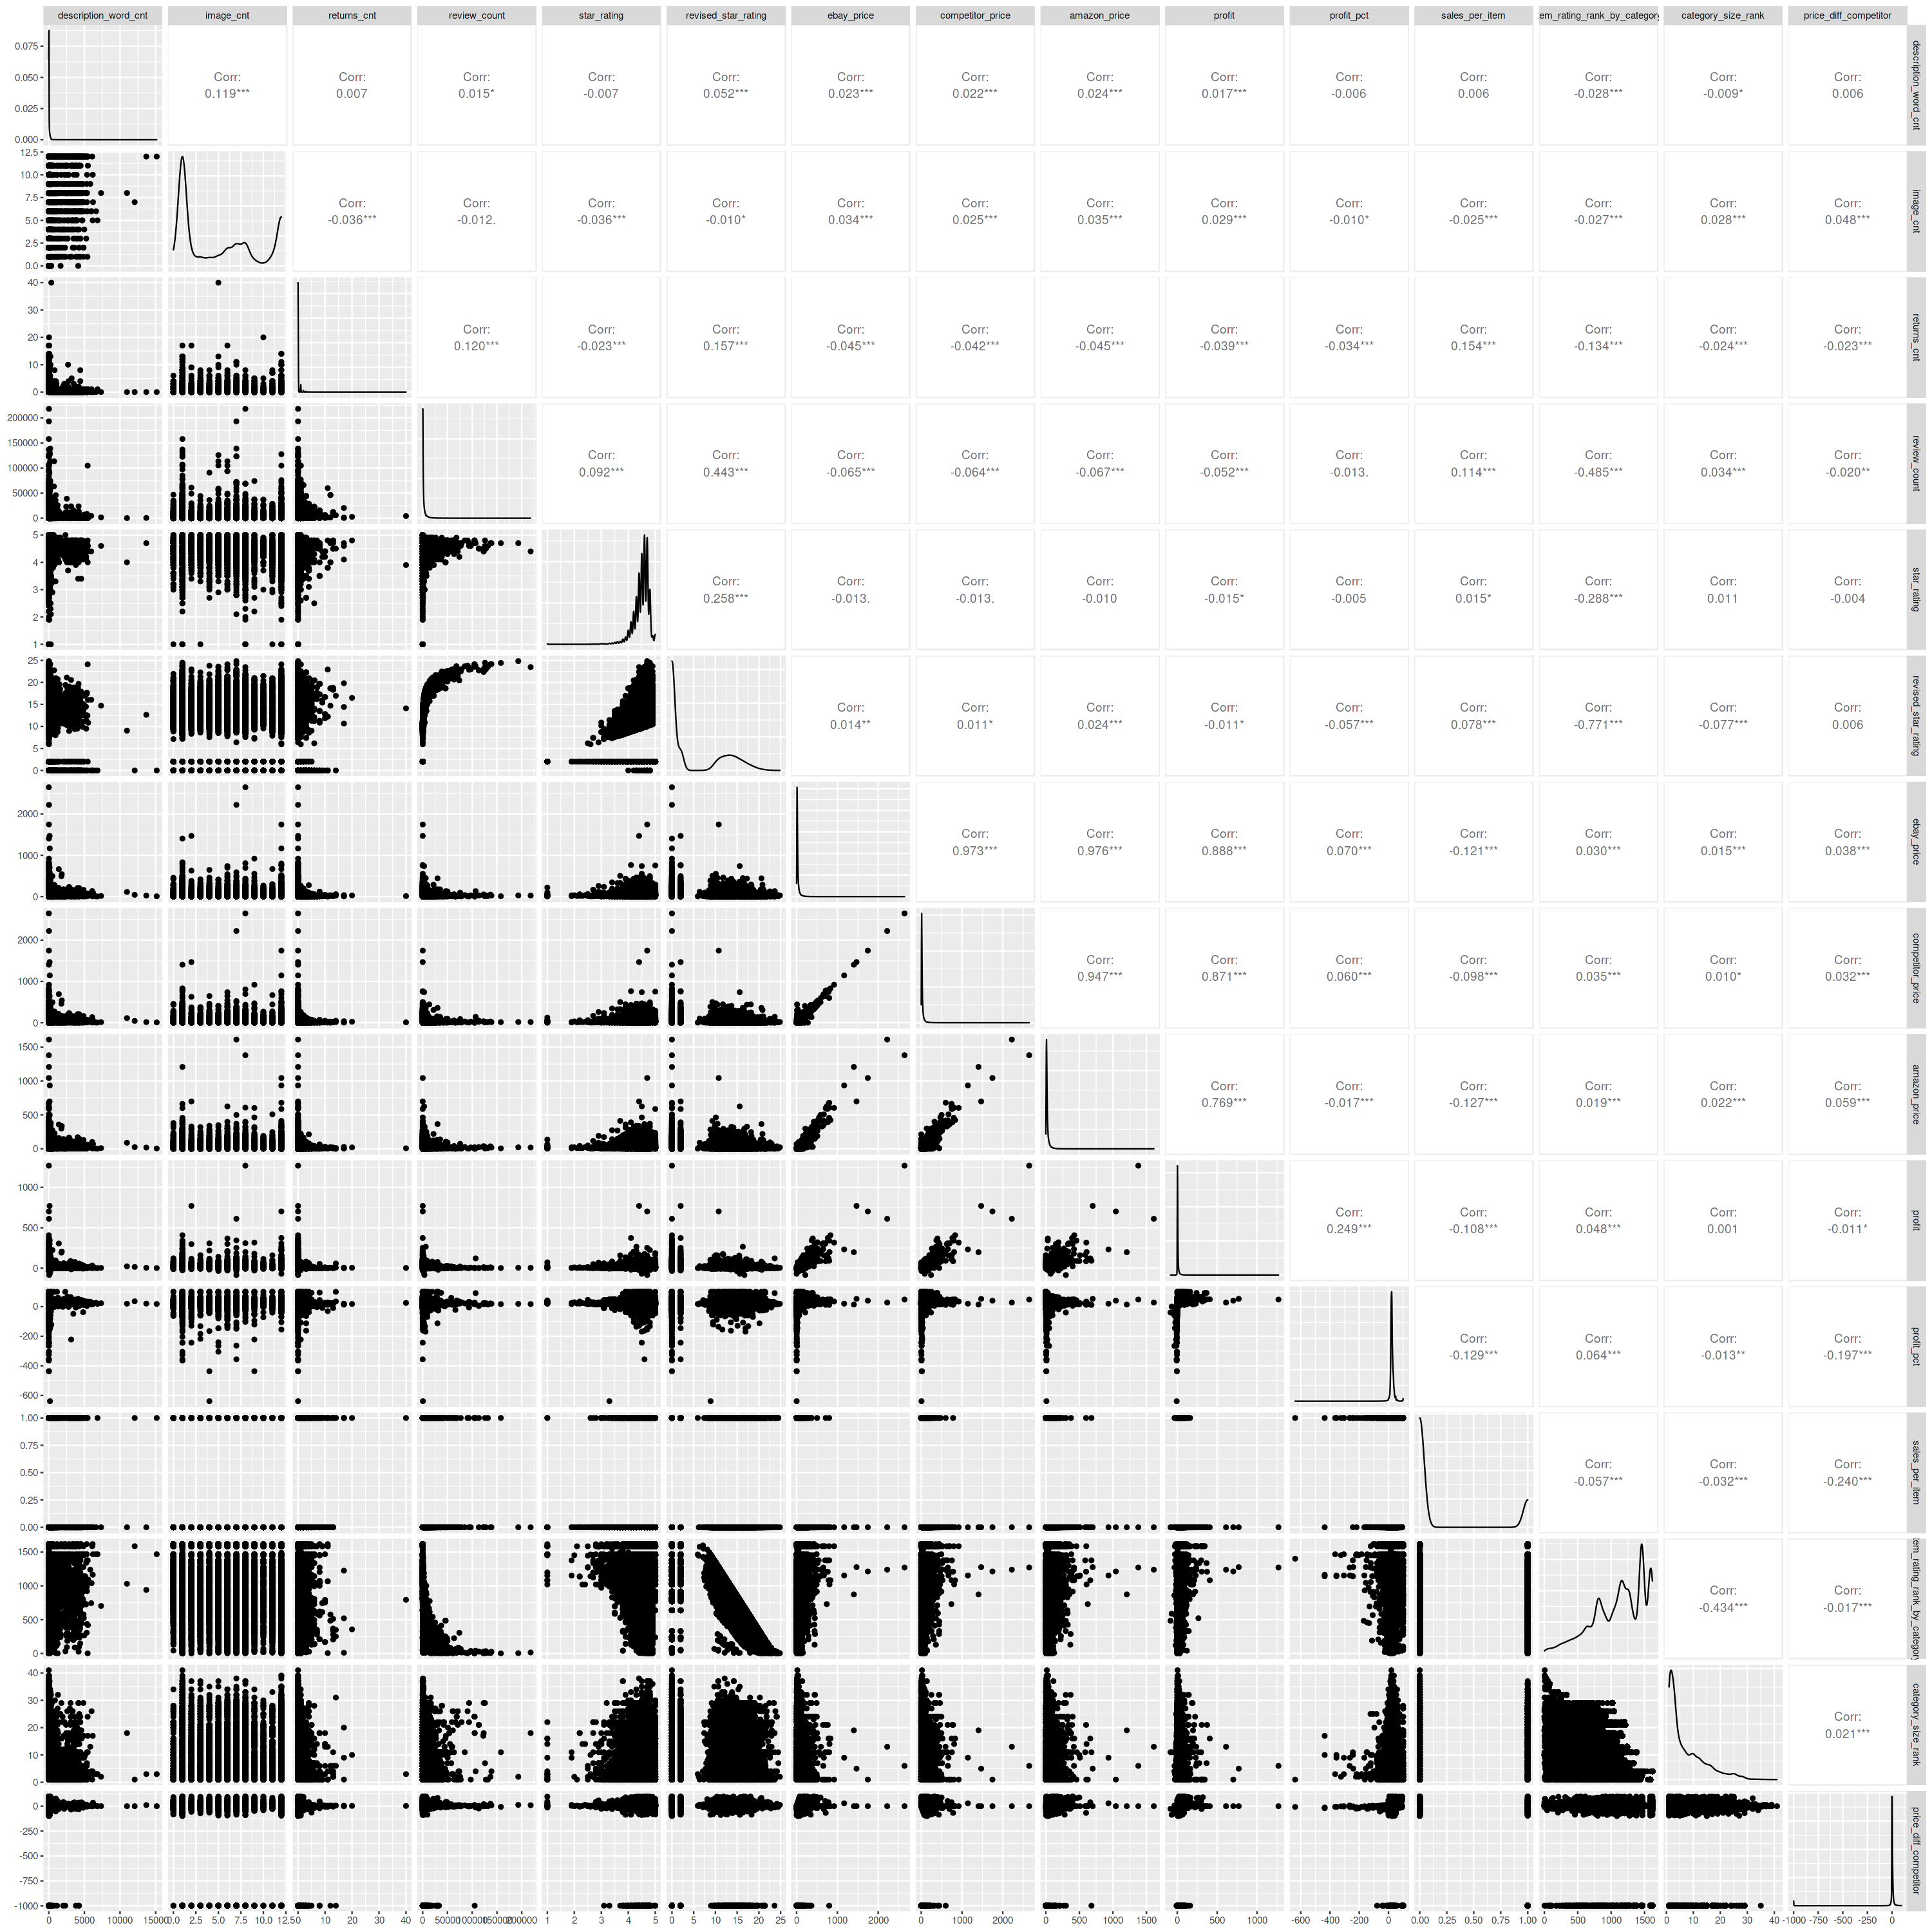

In [11]:
library(GGally)
options(repr.plot.width = 25, repr.plot.height = 25)
Items_sample <- sample_n(Items, 50000)
suppressWarnings(ggpairs(Items_sample[,numlst]))

**correlation matrix**

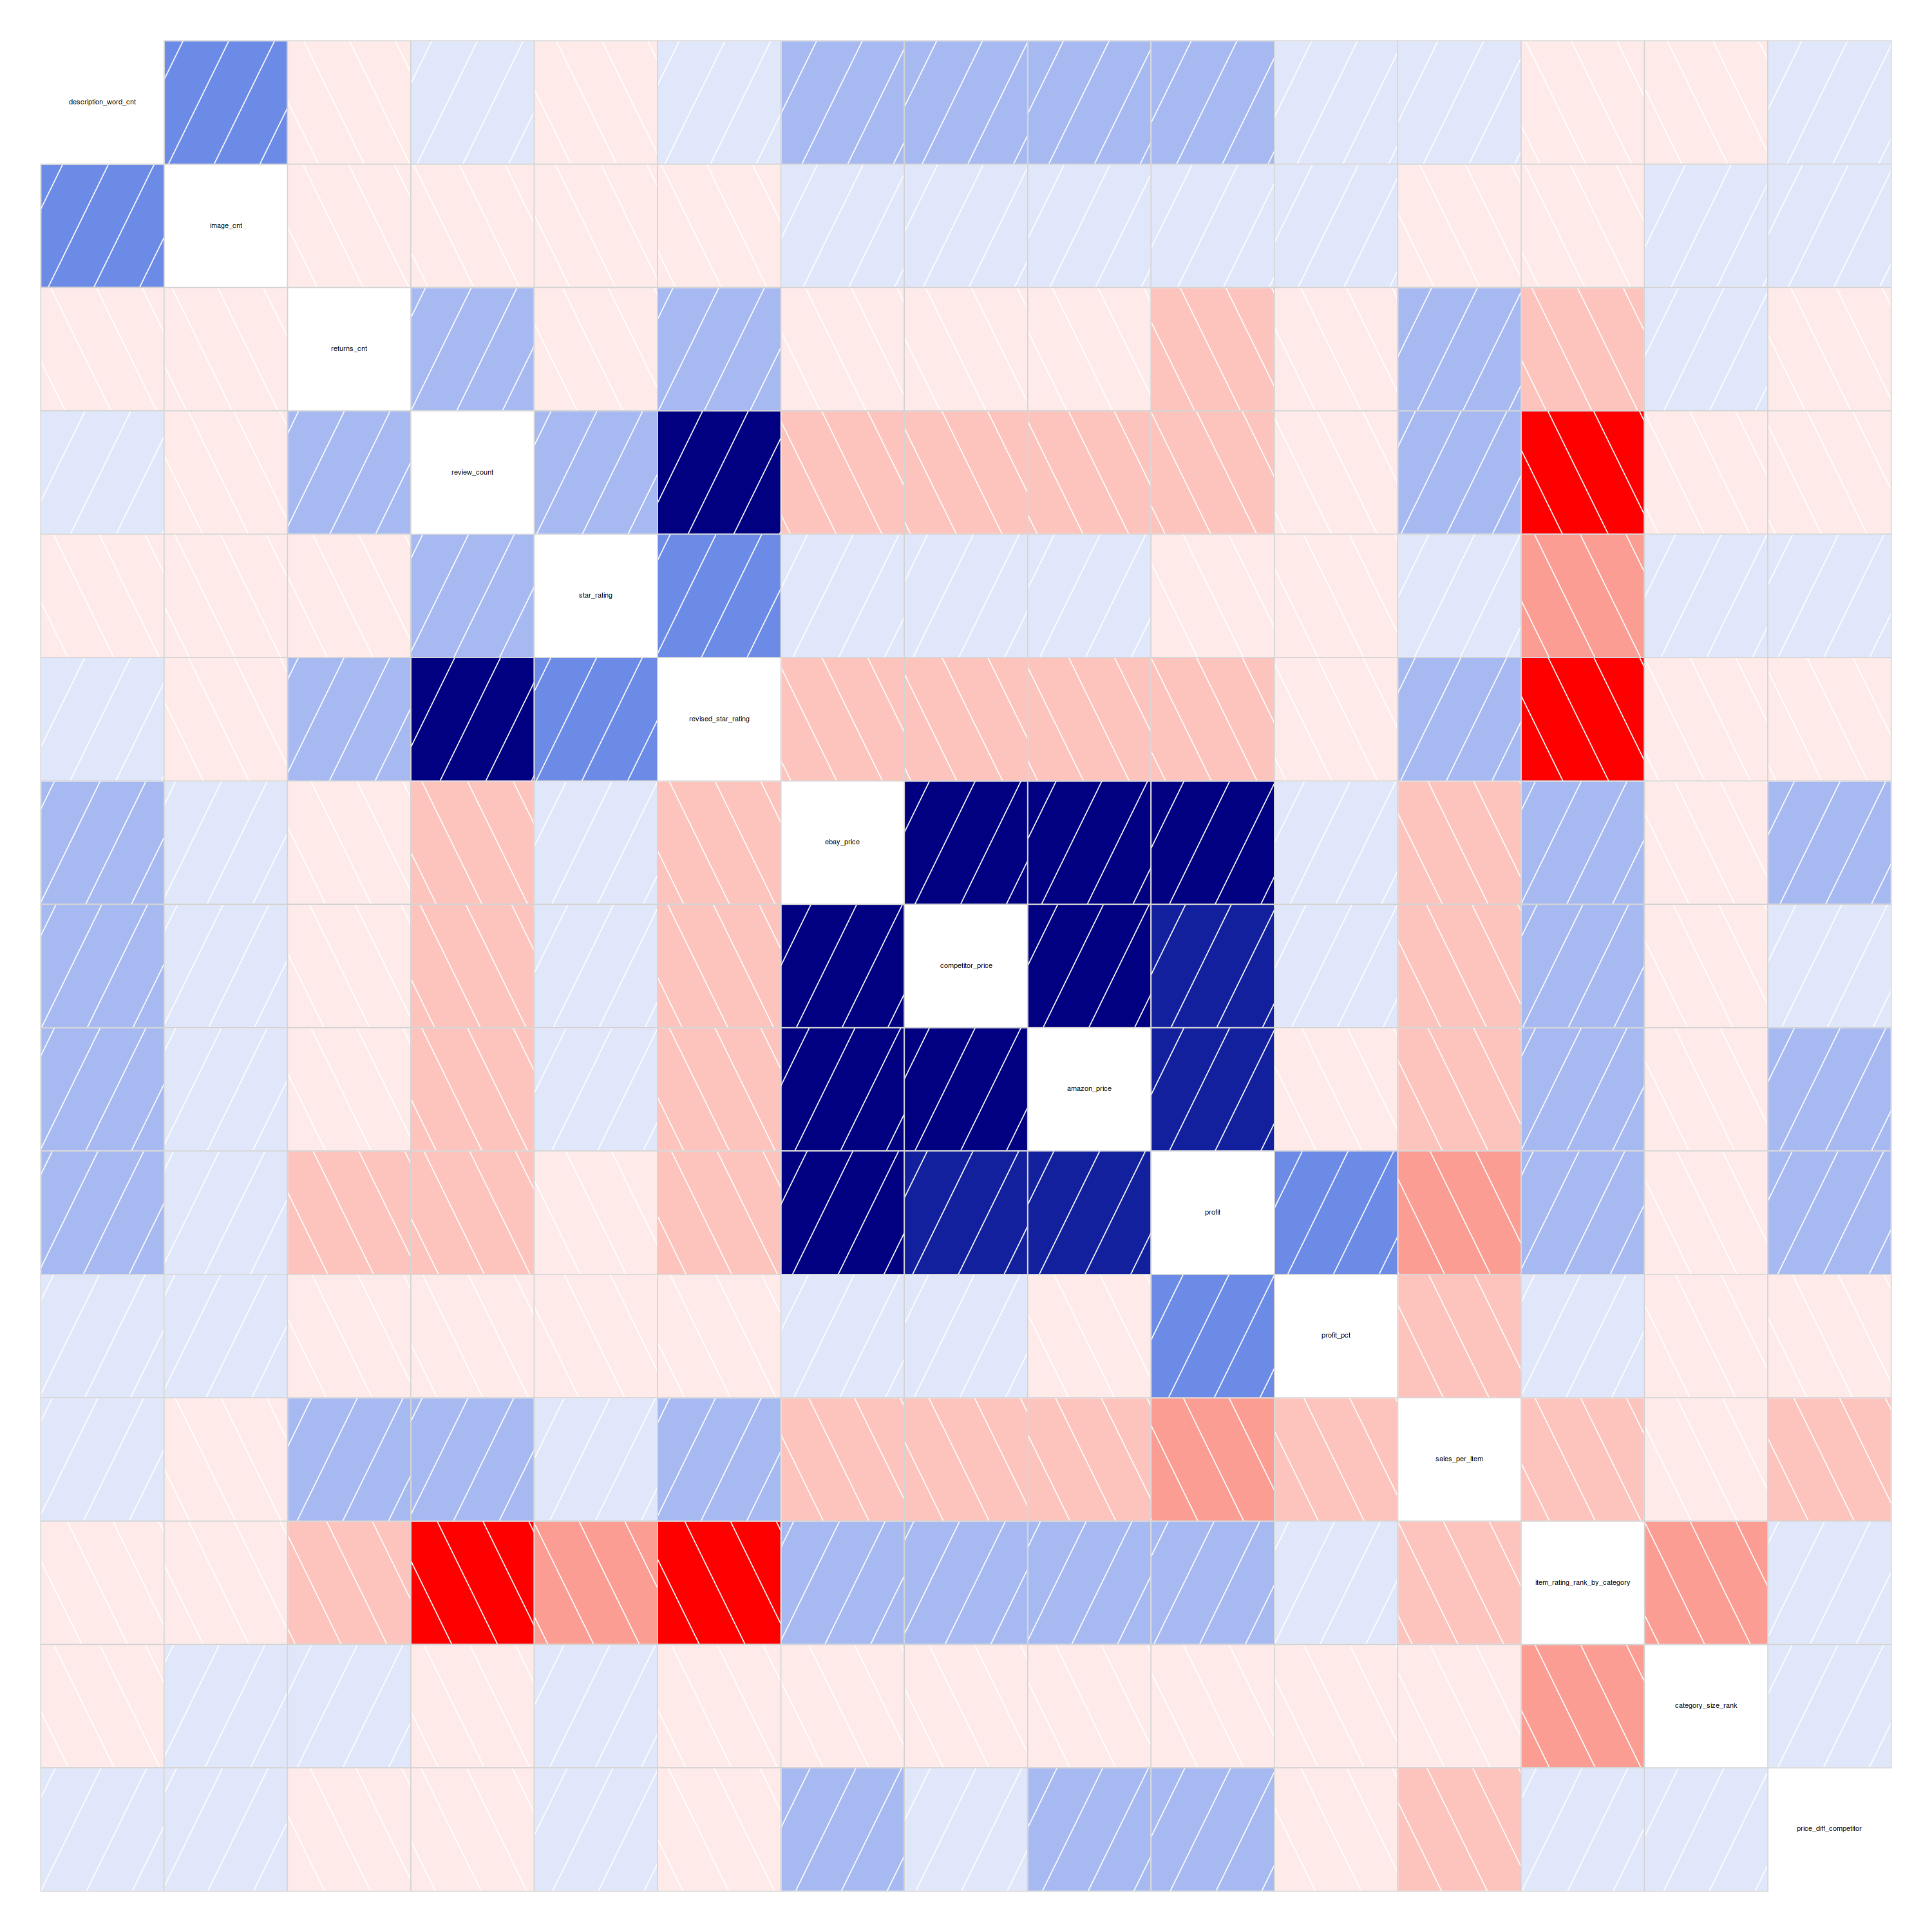

In [12]:
options(repr.plot.width = 25, repr.plot.height = 25)

dfcormat <- cor(Items[,numlst], use = "complete.obs", method = "spearman")
corrgram::corrgram(dfcormat)

,description_word_cnt,image_cnt,returns_cnt,review_count,star_rating,revised_star_rating,ebay_price,competitor_price,amazon_price,profit,profit_pct,sales_per_item,item_rating_rank_by_category,category_size_rank,price_diff_competitor
description_word_cnt,1.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0
image_cnt,0.1,1.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.1,0,0.0,0.0,0,0.1
returns_cnt,0.0,0.0,1.0,0.1,0.0,0.2,-0.1,-0.1,-0.1,-0.1,0,0.2,-0.2,0,0.0
review_count,0.0,0.0,0.1,1.0,0.1,0.4,0.0,0.0,0.0,0.0,0,0.1,-0.4,0,0.0
star_rating,0.0,0.0,0.0,0.1,1.0,0.3,0.0,0.0,0.0,0.0,0,0.0,-0.3,0,0.0
revised_star_rating,0.0,0.0,0.2,0.4,0.3,1.0,-0.2,-0.2,-0.2,-0.1,0,0.2,-0.9,0,0.0


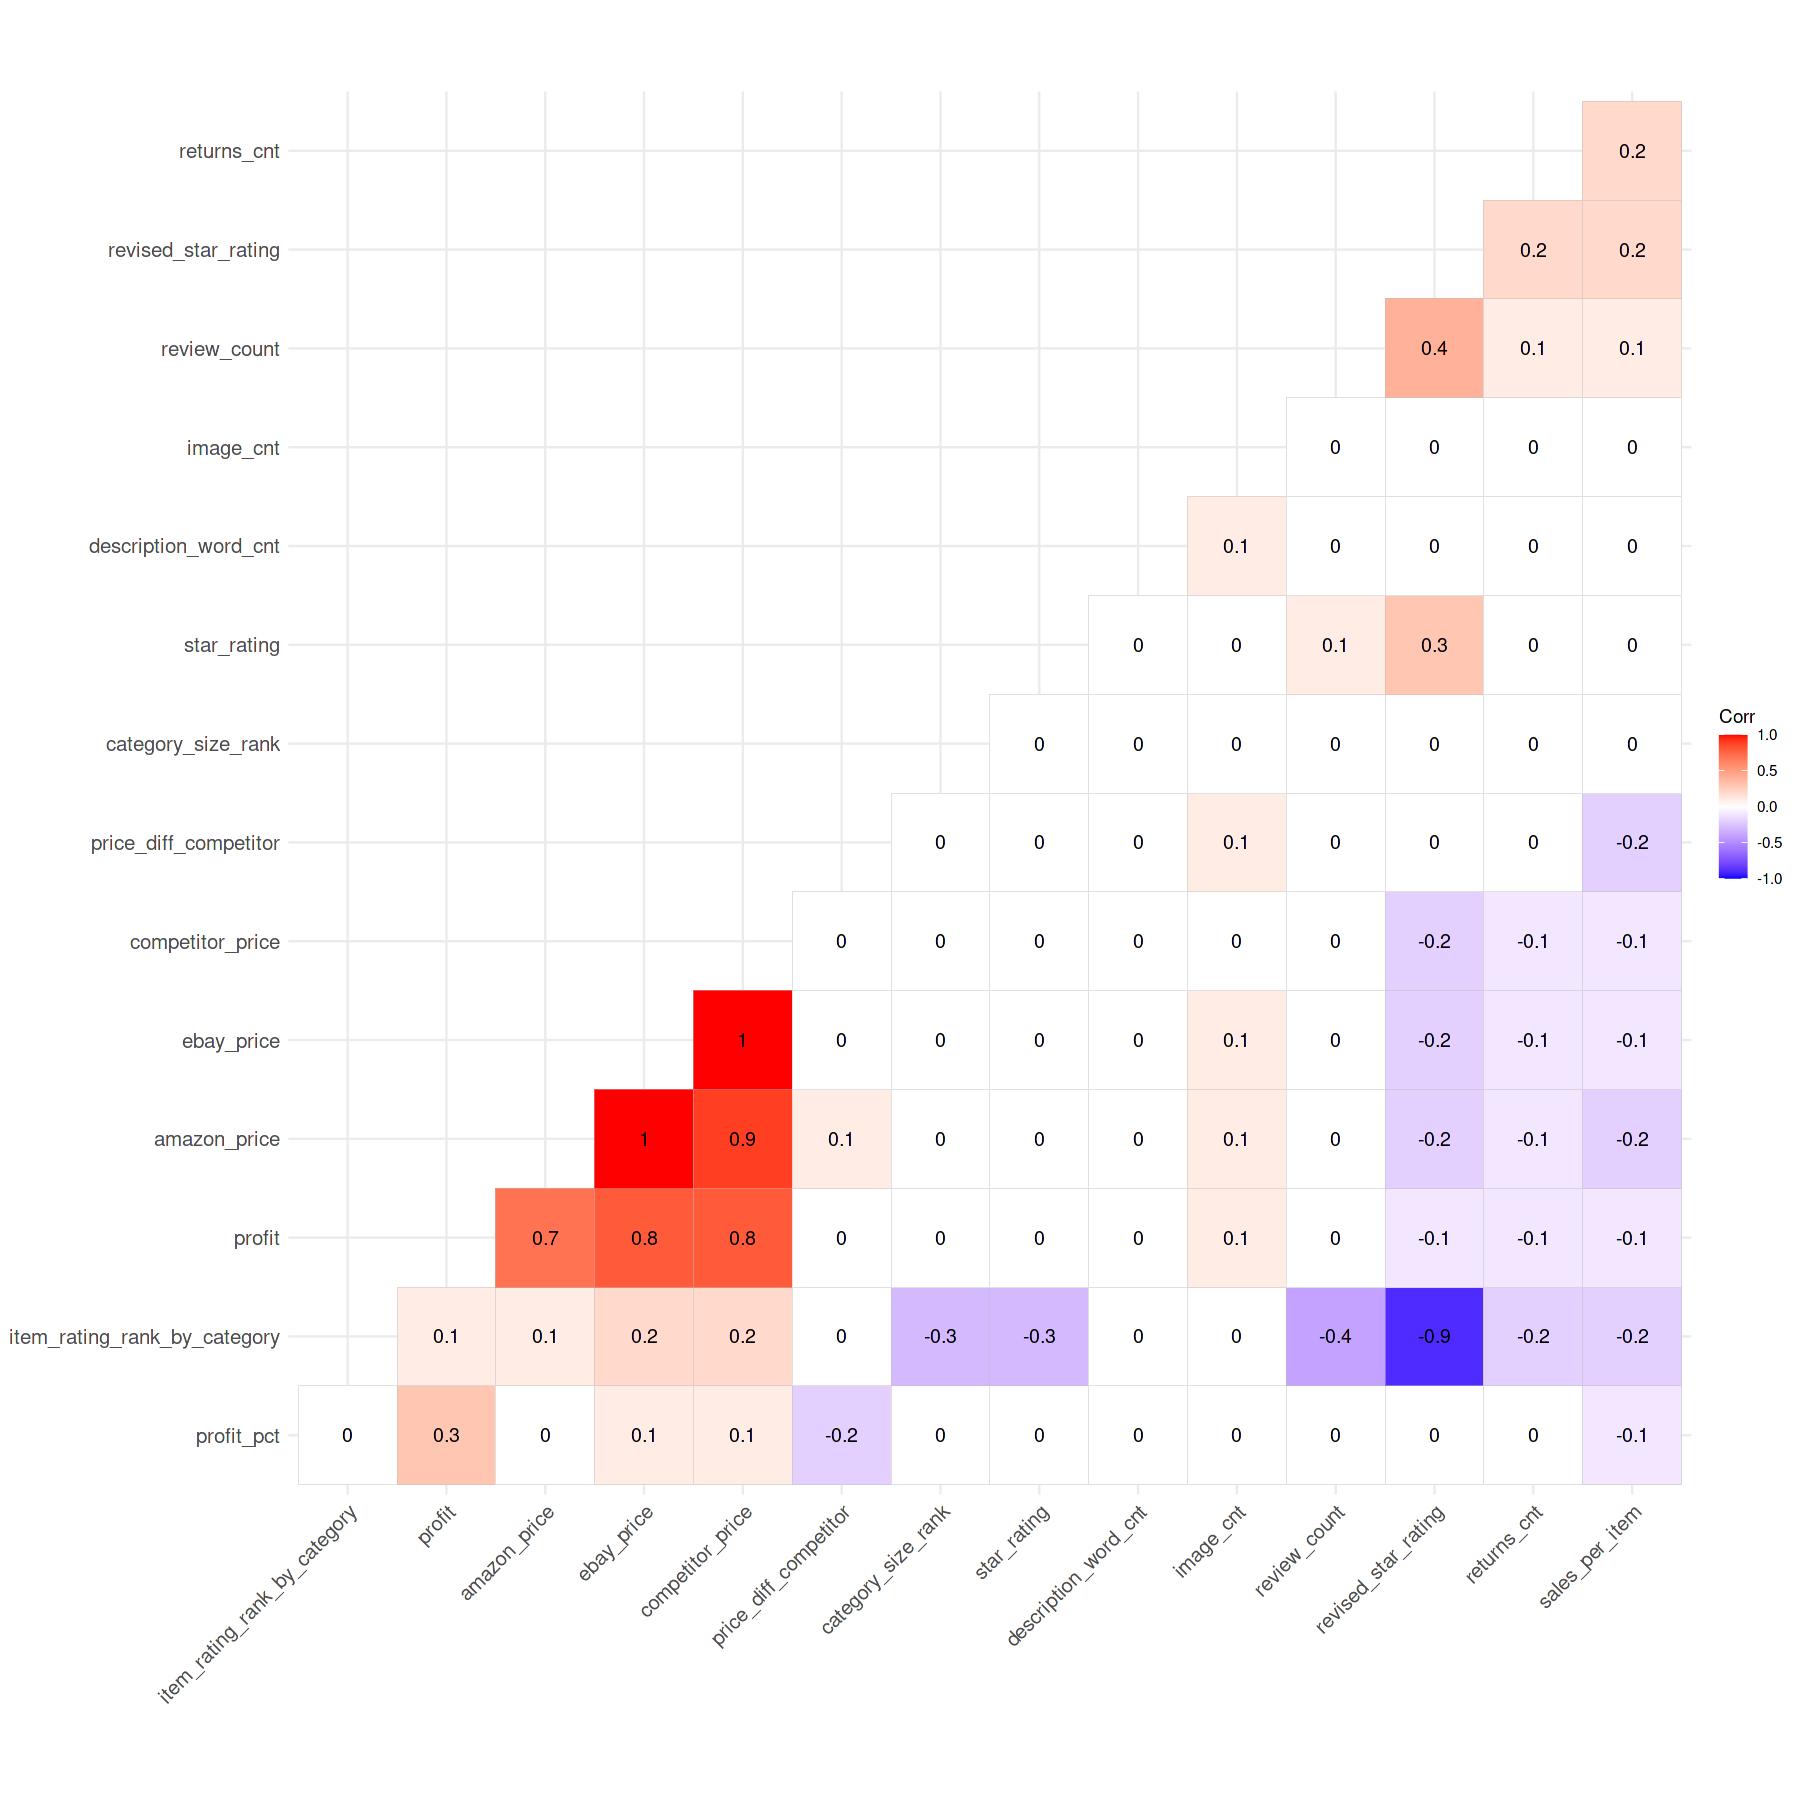

In [13]:
correlation_matrix <- round(cor(Items[,numlst], use = "complete.obs"), 1)
head(correlation_matrix[,]) # Show part of matrix

# Plot
options(repr.plot.width = 15, repr.plot.height = 15)
ggcorrplot(correlation_matrix,
           hc.order = TRUE,
           type = "lower",
           lab = TRUE)

In [14]:
library(lsr)
options(repr.plot.width = 25, repr.plot.height = 25)
res <- correlate(Items, corr.method = "spearman")

In [15]:
res$correlation
res$p.value

,asin,creation_time,season,location,condition,description,description_word_cnt,brand,category,image_cnt,⋯,sales_newyear,sales_xms,sales_per_item,success,item_rating_rank_by_category,category_size_rank,price_diff_competitor,brand_size,reviews_cnt_category,popular_brand
asin,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
creation_time,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
season,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
location,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
condition,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
description,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
description_word_cnt,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.275329909,⋯,NA,NA,0.02821567,0.02821567,0.040285339,-0.08953180,-0.0023060559,NA,NA,NA
brand,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
category,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
image_cnt,NA,NA,NA,NA,NA,NA,0.275329909,NA,NA,NA,⋯,NA,NA,-0.01249441,-0.01249441,-0.037838323,0.01186399,0.1081714508,NA,NA,NA


,asin,creation_time,season,location,condition,description,description_word_cnt,brand,category,image_cnt,⋯,sales_newyear,sales_xms,sales_per_item,success,item_rating_rank_by_category,category_size_rank,price_diff_competitor,brand_size,reviews_cnt_category,popular_brand
asin,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
creation_time,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
season,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
location,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
condition,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
description,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
description_word_cnt,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.000000e+00,⋯,NA,NA,4.169855e-87,4.169855e-87,5.530212e-177,0.000000e+00,4.118771e-01,NA,NA,NA
brand,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
category,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
image_cnt,NA,NA,NA,NA,NA,NA,0.000000e+00,NA,NA,NA,⋯,NA,NA,1.198980e-17,1.198980e-17,3.446300e-156,4.886993e-16,0.000000e+00,NA,NA,NA


In [16]:
res$correlation[res$correlation > 0.7]
& res$p.value[res$p.value < 0.05]]
m <- res$correlation
m[m[,] > 0.1]#[which(res$p.value < 0.05)]

ERROR: Error in parse(text = x, srcfile = src): <text>:2:1: unexpected '&'
1: res$correlation[res$correlation > 0.7]
2: &
   ^


**Cramer's V - measure of association between categorial variables**

In [ ]:
df1 <- data.frame(var1=character(),
                  var2=character(),
                  cramersV=numeric(),
                 P_value=numeric())

strlst1 <- c(strlst,'success')
i <- 1 
for (m in strlst1) {
    for (n in strlst1){
        if (m != n){
            suppressWarnings(cramersV <- cramersV(Items[[m]], Items[[n]]))
            suppressWarnings(chi <- chisq.test(Items[[m]], Items[[n]]))
            df1[i,] <- c(m,n,cramersV,chi$p.value)
            i <- i+1
        }
    }        
}
df1[(which(df1$cramersV > 0.8, arr.ind = TRUE)),]

# Outcome analysis : variable Success

In [ ]:
summary(Items$success)
str(Items$success)
table(Items$success)

**correlation between numeric variables and the outcome**

In [ ]:
outcome_corr <- res$correlation['success',numlst]
data.frame(outcome_corr)

In [ ]:
library(gridExtra)
library(grid)
library(ggplot2)
options(repr.plot.width = 20, repr.plot.height = 20)
p <- vector(mode = "list", length = length(numlst))
i <- 1
for (n in numlst) {
        p[[i]]<- ggplot(data=Items) + geom_boxplot(aes(x=success, y=.data[[n]]),outlier.shape = NA)+
                ggtitle(n)
        i <- i+1
}
suppressWarnings(grid.arrange(grobs=p, ncol=4))

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 20)
p <- vector(mode = "list", length = length(numlst))
i <- 1
for (n in numlst) {
        if (n %in% c('returns_cnt','image_cnt','star_rating','revised_star_rating')){
           p[[i]]<- ggplot(data=Items) +
                    geom_density(aes(x=.data[[n]], group=success, color=success))+xlim(0,15)+
                    ggtitle('success vs. ', n)
        }
        else {
            p[[i]]<- ggplot(data=Items) +
                    geom_density(aes(x=.data[[n]], group=success, color=success))+xlim(0,100)+
                    ggtitle('success vs. ', n)
              }
        i <- i+1
}
suppressWarnings(grid.arrange(grobs=p, ncol=3))

options(repr.plot.width = 5, repr.plot.height = 5)
ggplot(data=Items) +
    geom_density(aes(x=item_rating_rank_by_category, group=success, color=success))

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 5)
Items2 <- filter(Items,creation_time >= "2019-01-01" )
ggplot(data=Items2) +
                    geom_density(aes(x=creation_time, group=success, color=success))
                    ggtitle('success vs. creation_time')

**Check differences of categorial variables**

t test

In [ ]:
strlst2 <- strlst[c(2:11)] # exclude factors with more than 2 levels
for (n in strlst2) {
    mod <- t.test(Items$success ~ Items[[n]], var.equal = T, paired = F)
    if (mod$p.value < 0.05){
        print(n)}
}

**Association between categorial variables and the outcome**

In [ ]:
df1[(which(df1$var1 == 'success', arr.ind = TRUE)),] %>% arrange(desc(cramersV))# %>% filter(P_value < 0.05)

I found NO association with categorial variables

We see differences in :"location", "condition", "sales_cyber_monday", "sales_black_friday", "sales_colombus_day", "sales_labor_day", "sales_presidents_day", "sales_4th_july", "sales_newyear", "sales_xms"

The outcome is associated with reviews count, amazon price, profit and price_diff_competitor. 
When looking at prices - it seems that with low prices(<10) we see higher number of successful sale